In [ ]:
# Basic Libraries
import os
import glob
import numpy as np
import pandas as pd
import random
import math
from datetime import datetime
import warnings
import joblib

# Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib as mpl


# Image Processing
import rasterio
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float

# Signal Processing and Statistics
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import skew, kurtosis, entropy as scipy_entropy
from scipy.stats import entropy as scipy_entropy
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage import median_filter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform


# Time Series Analysis and Filtering
from pykalman import KalmanFilter
import nolds
from scipy.signal import wiener
import bm3d
from tqdm import tqdm
from scipy.ndimage import uniform_filter
from numpy.lib.stride_tricks import sliding_window_view


# Coordinate Transformation
from pyproj import Transformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, precision_score, precision_recall_curve
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
from imblearn.over_sampling import SMOTE
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.datasets import load_arrow_head
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.pipeline import make_pipeline
from sktime.classification.deep_learning.inceptiontime import InceptionTimeClassifier


In [3]:
# Add MiKTeX bin directory to PATH
os.environ['PATH'] += os.pathsep + r'C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64'

# Verify the update
print("Updated PATH:")
print(os.environ['PATH'])

# Print LaTeX configuration
print("LaTeX configuration:")
print(os.popen("latex --version").read())


Updated PATH:
c:\Users\olive\AppData\Local\Programs\Python\Python311;c:\Users\olive\AppData\Roaming\Python\Python311\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Common Files\Oracle\Java\java8path;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\dotnet\;C:\Program Files\Pandoc\;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Microsoft\WindowsApps;C:\Users\olive\AppData\Local\Programs\Microsoft VS Code\bin;C:\Program Files\esa-snap\bin;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64\;C:\Prog

In [4]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,    # X-axis tick labels font size
    'ytick.labelsize': 9,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [5]:
df=pd.read_csv('saved_attribute_table.csv')
attribute_table2=pd.read_csv('attribute_table_2.csv')

In [6]:
# Ensure the 'fid' column is the index in both dataframes
df.set_index('fid', inplace=True)
attribute_table2.set_index('fid', inplace=True)

# Update the centroid_x and centroid_y columns in df with the values from attribute_table2
df.update(attribute_table2[['centroid_x', 'centroid_y']])

# Reset the index to return 'fid' as a column
df.reset_index(inplace=True)

In [7]:
def check_forest_mask(tif_path, utm_x, utm_y, proj):
    """
    Returns forest coverage for a given point
    
    Parameters:
    tif_path (str): The path to the forest coverage file.
    utm_x (float): The UTM easting coordinate.
    utm_y (float): The UTM northing coordinate.
    
    Returns:
    int: Forest coverage percentage
    """

    with rasterio.open(tif_path) as dataset:
        # Initialize the transformer
        transformer_to_raster_crs = Transformer.from_crs(proj, dataset.crs, always_xy=True)
        
        # Convert UTM coordinates to the raster's CRS
        raster_x, raster_y = transformer_to_raster_crs.transform(utm_x, utm_y)
        
        # Calculate the pixel coordinates
        pixel_col, pixel_row = ~dataset.transform * (raster_x, raster_y)
        pixel_col = int(pixel_col)
        pixel_row = int(pixel_row)

        
        # Check if the pixel coordinates are within the raster's dimensions
        if 0 <= pixel_col < dataset.width and 0 <= pixel_row < dataset.height:
            # Read the value at the pixel coordinates
            data = dataset.read(1, window=((pixel_row, pixel_row + 1), (pixel_col, pixel_col + 1)))
            pixel_value = data[0, 0]
            return pixel_value
        else:
            return None


def generate_random_coordinates(center, radius, num_points=10):
    """
    Generate random coordinates within a given radius from a center point.
    
    Parameters:
    center (tuple): A tuple containing the UTM coordinates of the center point (easting, northing).
    radius (float): The radius within which to generate the random points (in meters).
    num_points (int): The number of random points to generate. Default is 10.
    
    Returns:
    list: A list of tuples containing the UTM coordinates of the random points.
    """
    center_easting, center_northing = center
    points = []
    valid_points = 0

    if str(center_easting).startswith('21'):
        tif_path = '00N_060W.tif'
        proj='EPSG:29181'
    else:
        tif_path = '00N_070W.tif'
        proj='EPSG:32720'


    while valid_points < num_points:
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        
        offset_easting = distance * math.cos(angle)
        offset_northing = distance * math.sin(angle)
        
        new_easting = center_easting + offset_easting
        new_northing = center_northing + offset_northing
        
        pixel_value = check_forest_mask(tif_path, new_easting, new_northing,proj)
        
        if pixel_value == 100:  ## verify its forest
            points.append((new_easting, new_northing))
            valid_points += 1
        else:
            continue
    
    return points

In [8]:
def list_tif_files(folder_path):
    return sorted(glob.glob(os.path.join(folder_path, '*.tif')))

In [9]:
def utm_to_pixel(dataset, utm_x, utm_y):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x), int(pixel_y)

In [10]:
def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [11]:
def read_gap_coordinates(gap_number, df):
    """
    Given a gap number, return the centroid coordinates from the DataFrame.
    
    Parameters:
    gap_number (int): The gap number (1-based index).
    df (pd.DataFrame): The DataFrame containing the coordinates.
    
    Returns:
    tuple: A tuple containing the (x, y) coordinates.
    """
    # Convert 1-based index to 0-based index
    row_index = gap_number - 1
    
    # Get the coordinates from the DataFrame
    x_coord = df.at[row_index, 'centroid_x']
    y_coord = df.at[row_index, 'centroid_y']
    
    return (x_coord, y_coord)

# Example usage
gap_number = 82
coordinates = read_gap_coordinates(gap_number, df)
print(f"Coordinates for gap{gap_number}: {coordinates}")

Coordinates for gap82: (217941.875567938, 9551027.85076804)


In [12]:
def extract_time_series_for_coordinate(folder_path, coord, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    # Loop through each .tif file
    for tif_file in tif_files:
        # Extract the date from the filename
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        # Get pixel value for the specified coordinate
        coord_value = get_pixel_value(tif_file, coord[0], coord[1], filter != 'False')
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    # Apply the chosen filter
    if filter == 'kalman':
        kf = KalmanFilter(initial_state_mean=coord_values[0], n_dim_obs=1)
        coord_values, _ = kf.smooth(coord_values)  # Extract the smoothed state estimates
        coord_values = coord_values.flatten()
    elif filter == 'savgol':
        coord_values = savgol_filter(coord_values, window_length=5, polyorder=2)

    return dates, coord_values


def extract_time_series_for_random_points(folder_path, center_coord, radius, num_points, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    random_points_time_series = [[] for _ in range(num_points)]

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            coord_value = get_pixel_value(tif_file, utm_x, utm_y, filter != 'False')
            random_points_time_series[i].append(coord_value)

    if scale:
        random_points_time_series = [[10**(value / 10) for value in series] for series in random_points_time_series]

    # Apply the chosen filter
    if filter == 'kalman':
        for i in range(num_points):
            kf = KalmanFilter(initial_state_mean=random_points_time_series[i][0], n_dim_obs=1)
            random_points_time_series[i], _ = kf.smooth(random_points_time_series[i])  # Extract the smoothed state estimates
            random_points_time_series[i] = random_points_time_series[i].flatten()
    elif filter == 'savgol':
        random_points_time_series = [savgol_filter(series, window_length=5, polyorder=2) for series in random_points_time_series]

    return dates, random_points_time_series


def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [13]:
folder_path = 'downloaded_files/gap83'
coord = read_gap_coordinates(83,df)
dates, coord_values = extract_time_series_for_random_points(folder_path, coord,100,10, filter=False, scale=True)

In [16]:
def add_time_series_to_df(series_dataframe_, gap_folder, attribute_table,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])
    
    # Get the coordinates for the current gap folder
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    
    # Extract the time series data for the current gap folder
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    # Create a DataFrame for the current gap folder
    gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}': coord_values})
    
    # Set the 'Date' column as the index
    gap_df.set_index('Date', inplace=True)
    
    # Merge with the main DataFrame, aligning on the 'Date' index
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def add_random_time_series_to_df(series_dataframe_, gap_folder, center_coord, num_points=3, radius=100, attribute_table=None,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])

    # Extract the time series data for random points in the current gap folder
    dates, random_points_time_series = extract_time_series_for_random_points(gap_folder, center_coord, radius, num_points, filter=filterp, scale=scalep)

    # Create a DataFrame for the random points time series
    for i in range(num_points):
        gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}_random{i+1}': random_points_time_series[i]})
        gap_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')

    return series_dataframe_

In [17]:
def process_gap_folders(base_folder, df, series_dataframe, random_series_dataframe, filterp=False, scalep=False,np=3):
    """
    Processes gap folders and adds time series data to given dataframes.

        base_folder (str): The base folder containing gap folders.
        df (pd.DataFrame): The dataframe with gap information.
        series_dataframe (pd.DataFrame): Dataframe to add gap time series data to.
        random_series_dataframe (pd.DataFrame): Dataframe to add random time series data to.
        np: number of random points, default is 3
    """
    # Create a list of all folders/filepaths for all gaps
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    # Iterate over each gap folder and process the data
    for gap_folder in gap_folders:
        series_dataframe = add_time_series_to_df(series_dataframe, gap_folder, df, filterp=filterp, scalep=scalep)

        gap_number = int(gap_folder.split('gap')[-1])
        center_coord = read_gap_coordinates(gap_number, df)
        random_series_dataframe = add_random_time_series_to_df(random_series_dataframe, gap_folder, center_coord, num_points=np, radius=200, attribute_table=df, filterp=filterp, scalep=scalep)

    return series_dataframe, random_series_dataframe

# Extract time series for neighbours functions

In [18]:
start_date = datetime(2017, 11, 11)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

df_gen1 = pd.DataFrame(index=date_range)
df_gen2 = pd.DataFrame(index=date_range)

In [19]:
# Function to convert UTM coordinates to pixel coordinates with an offset
def unique_utm_to_pixel(dataset, utm_x, utm_y, offset_x=0, offset_y=0):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x) + offset_x, int(pixel_y) + offset_y


# Function to get pixel value from a TIF file for a given UTM coordinate
def unique_get_pixel_value(tif_file, utm_x, utm_y, offset_x=0, offset_y=0, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        band1 = dataset.read(1)
        
        if apply_filter:
            band1_float = img_as_float(band1)
            sigma_est = np.mean(estimate_sigma(band1_float))
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            image_data = denoised_band1
        else:
            image_data = band1

        pixel_x, pixel_y = unique_utm_to_pixel(dataset, utm_x, utm_y, offset_x, offset_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value


# Function to extract time series for a given coordinate
def unique_extract_time_series_for_coordinate(folder_path, coord, offset_x=0, offset_y=0, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        coord_value = unique_get_pixel_value(tif_file, coord[0], coord[1], offset_x, offset_y, apply_filter=(filter != 'False'))
        coord_values.append(coord_value)

    return dates, coord_values


# Function to extract time series for surrounding pixels
def unique_extract_time_series_for_surrounding_pixels(folder_path, central_coord, filter=False, scale=False):
    # Define offsets for the 25 positions in the 5x5 grid (including corners)
    offsets = [
        (-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2),
        (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2),
        (0, -2),  (0, -1),  (0, 0),  (0, 1),  (0, 2),
        (1, -2),  (1, -1),  (1, 0),  (1, 1),  (1, 2),
        (2, -2),  (2, -1),  (2, 0),  (2, 1),  (2, 2)
    ]
    
    all_time_series = {}
    dates = None

    for offset_x, offset_y in offsets:
        current_dates, current_series = unique_extract_time_series_for_coordinate(folder_path, central_coord, offset_x, offset_y, filter, scale)
        if dates is None:
            dates = current_dates
        offset_key = f"{offset_x},{offset_y}"
        all_time_series[offset_key] = current_series

    return dates, all_time_series


# Function to add time series with surrounding pixels to DataFrame
def unique_add_time_series_with_surrounding_pixels_to_df(series_dataframe_, gap_folder, attribute_table, filterp=False, scalep=False):
    gap_number = int(gap_folder.split('gap')[-1])
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    dates, all_coord_values = unique_extract_time_series_for_surrounding_pixels(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    # Construct a dictionary with the new naming convention
    data = {f'gap{gap_number}_{offset}': values for offset, values in all_coord_values.items()}
    data['Date'] = dates

    # Create a DataFrame from the data dictionary
    gap_df = pd.DataFrame(data)
    gap_df.set_index('Date', inplace=True)

    # Merge the new DataFrame with the existing one
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_

# Function to process gap folders and add time series data to DataFrame
def unique_process_gap_folders_with_surrounding_pixels(base_folder, df, series_dataframe, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        print(gap_folder)
        series_dataframe = unique_add_time_series_with_surrounding_pixels_to_df(series_dataframe, gap_folder, df, filterp=filterp, scalep=scalep)

    return series_dataframe


In [20]:
def extract_time_series_for_random_points_with_neighbors(folder_path, center_coord, radius, num_points, filter=False, scale=False):
    # Generate random coordinates within the specified radius
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    all_time_series_random = []

    # List all TIF files in the folder
    tif_files = list_tif_files(folder_path)
    dates = []

    # Initialize the nested list structure for 25 offsets
    for i in range(num_points):
        all_time_series_random.append([[] for _ in range(25)])

    # Define offsets for the 25 positions in the 5x5 grid (including corners)
    offsets = [
        (-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2),
        (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2),
        (0, -2),  (0, -1),  (0, 0),  (0, 1),  (0, 2),
        (1, -2),  (1, -1),  (1, 0),  (1, 1),  (1, 2),
        (2, -2),  (2, -1),  (2, 0),  (2, 1),  (2, 2)
    ]

    # Extract time series for each random point and its neighbors
    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            for j, (offset_x, offset_y) in enumerate(offsets):
                coord_value = unique_get_pixel_value(tif_file, utm_x, utm_y, offset_x, offset_y, filter != 'False')
                all_time_series_random[i][j].append(coord_value)

    # No scaling or additional filtering applied

    return dates, all_time_series_random


def unique_add_time_series_for_random_points_to_df(series_dataframe_, gap_folder, attribute_table, radius=50, num_points=3, filterp=False, scalep=False):
    gap_number = int(gap_folder.split('gap')[-1])
    gap_coord = read_gap_coordinates(gap_number, attribute_table)

    # Extract the time series data for random points and their neighbors
    dates, all_time_series_random = extract_time_series_for_random_points_with_neighbors(gap_folder, gap_coord, radius, num_points, filter=filterp, scale=scalep)
    
    # Define offsets for the 25 positions in the 5x5 grid (including corners)
    offsets = [
        (-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2),
        (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2),
        (0, -2),  (0, -1),  (0, 0),  (0, 1),  (0, 2),
        (1, -2),  (1, -1),  (1, 0),  (1, 1),  (1, 2),
        (2, -2),  (2, -1),  (2, 0),  (2, 1),  (2, 2)
    ]
    
    # Format offsets as strings for labeling
    offset_labels = [f'{x},{y}' for x, y in offsets]
    
    for i in range(num_points):
        data = {f'gap{gap_number}_random{i+1}_{offset_label}': all_time_series_random[i][j] for j, offset_label in enumerate(offset_labels)}
        data['Date'] = dates
        
        random_df = pd.DataFrame(data)
        random_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(random_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def unique_process_gap_folders_with_surrounding_pixels_random(base_folder, df, series_dataframe,radius,np_=3, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        print(gap_folder)
        series_dataframe = unique_add_time_series_for_random_points_to_df(series_dataframe, gap_folder, df,radius=50,num_points=np_, filterp=filterp, scalep=scalep)

    return series_dataframe


### Extract time series with neighbours

In [21]:
# Example usage
df_series_2yr_gaps_with_neighbours = unique_process_gap_folders_with_surrounding_pixels('downld_2yr_12dayinterval', df, df_gen1, filterp=False, scalep=False)

df_series_2yr_random_with_neighbours=unique_process_gap_folders_with_surrounding_pixels_random('downld_2yr_12dayinterval',df,df_gen1,40,3)

downld_2yr_12dayinterval\gap1
downld_2yr_12dayinterval\gap10
downld_2yr_12dayinterval\gap100
downld_2yr_12dayinterval\gap101
downld_2yr_12dayinterval\gap102
downld_2yr_12dayinterval\gap103
downld_2yr_12dayinterval\gap104
downld_2yr_12dayinterval\gap105
downld_2yr_12dayinterval\gap106
downld_2yr_12dayinterval\gap107
downld_2yr_12dayinterval\gap11
downld_2yr_12dayinterval\gap12
downld_2yr_12dayinterval\gap13
downld_2yr_12dayinterval\gap14
downld_2yr_12dayinterval\gap15
downld_2yr_12dayinterval\gap16
downld_2yr_12dayinterval\gap17
downld_2yr_12dayinterval\gap18
downld_2yr_12dayinterval\gap19
downld_2yr_12dayinterval\gap2
downld_2yr_12dayinterval\gap20
downld_2yr_12dayinterval\gap21
downld_2yr_12dayinterval\gap22
downld_2yr_12dayinterval\gap23
downld_2yr_12dayinterval\gap24
downld_2yr_12dayinterval\gap25
downld_2yr_12dayinterval\gap26
downld_2yr_12dayinterval\gap27
downld_2yr_12dayinterval\gap28
downld_2yr_12dayinterval\gap29
downld_2yr_12dayinterval\gap3
downld_2yr_12dayinterval\gap30
dow

## Create time series dataframes

In [22]:
## form generic dataframes ##

start_date = datetime(2017, 11, 11)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

df_gen1 = pd.DataFrame(index=date_range)
df_gen2 = pd.DataFrame(index=date_range)

In [565]:
df_series_alltime_gaps, df_series_alltime_random = process_gap_folders('downloaded_files', df, df_gen1, df_gen2, filterp=False, scalep=False)

df_series_2yr_gaps_plot, df_series_2yr_random_plot = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp=False, scalep=False)

In [560]:
## Shorten the indefinete / alltime random dataframe so we can compare

def keep_first_two_years(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        # Find the first non-NaN entry in the column
        first_valid_index = df_copy[column].first_valid_index()
        
        if first_valid_index is not None:
            # Calculate the date two years after the first non-NaN entry
            cutoff_date = first_valid_index + pd.DateOffset(years=2)
            
            # Set all entries after the cutoff date to NaN
            df_copy.loc[df_copy.index > cutoff_date, column] = pd.NA

    return df_copy

# Applying the function to the dataframe
df_series_alltime_random_reduced = keep_first_two_years(df_series_alltime_random)
df_series_alltime_gaps_reduced = keep_first_two_years(df_series_alltime_gaps)

## Analyse slopes on time series

In [562]:
# Function to plot aggregate statistics for two dataframes on a single plot
def plot_aggregates(df1, df2, title1, title2, df3, df4, title3, title4):
    # Calculate the mean and standard deviation for the first dataframe set
    mean_series1 = df1.mean(axis=1, skipna=True).dropna()
    std_series1 = df1.std(axis=1, skipna=True).dropna()
    
    mean_series2 = df2.mean(axis=1, skipna=True).dropna()
    std_series2 = df2.std(axis=1, skipna=True).dropna()
    
    # Calculate the mean and standard deviation for the second dataframe set
    mean_series3 = df3.mean(axis=1, skipna=True).dropna()
    std_series3 = df3.std(axis=1, skipna=True).dropna()
    
    mean_series4 = df4.mean(axis=1, skipna=True).dropna()
    std_series4 = df4.std(axis=1, skipna=True).dropna()
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.2, 5.5), sharex=True, sharey=True)
    
    # Plot for the first dataframe set
    ax1.plot(mean_series1, label=f'{title1} Mean', color='#FF0000')
    # ax1.fill_between(mean_series1.index, mean_series1 - std_series1, mean_series1 + std_series1, color='blue', alpha=0.2, label=f'{title1} Standard Deviation')
    
    ax1.plot(mean_series2, label=f'{title2} Mean', color='#0000FF')
    # ax1.fill_between(mean_series2.index, mean_series2 - std_series2, mean_series2 + std_series2, color='green', alpha=0.2, label=f'{title2} Standard Deviation')
    
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Pixel Values')
    ax1.text(1.02, 0.5, '(a)', transform=ax1.transAxes, verticalalignment='center', fontweight='bold')

    
    # Plot for the second dataframe set
    ax2.plot(mean_series3, label=f'{title3} Mean', color='#FF0000')
    # ax2.fill_between(mean_series3.index, mean_series3 - std_series3, mean_series3 + std_series3, color='blue', alpha=0.2, label=f'{title3} Standard Deviation')
    
    ax2.plot(mean_series4, label=f'{title4} Mean', color='#0000FF')
    # ax2.fill_between(mean_series4.index, mean_series4 - std_series4, mean_series4 + std_series4, color='green', alpha=0.2, label=f'{title4} Standard Deviation')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Pixel Values')
    ax2.legend()
    ax2.grid(True)
    ax2.text(1.02, 0.5, '(b)', transform=ax2.transAxes, verticalalignment='center', fontweight='bold')

    
    plt.tight_layout()


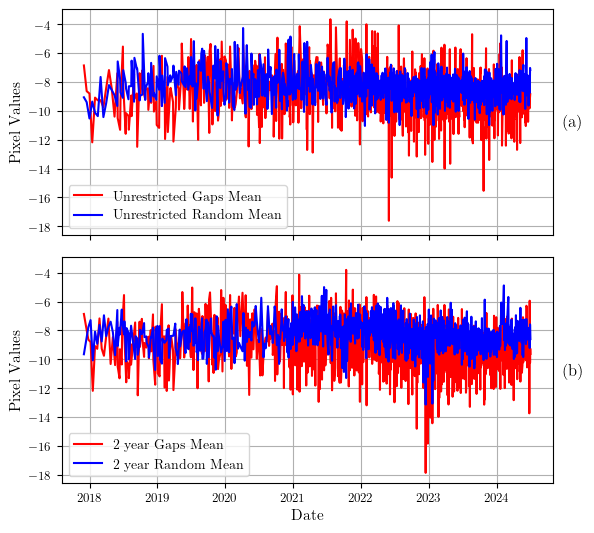

In [566]:
plot_aggregates(df_series_alltime_gaps, df_series_alltime_random, 'Unrestricted Gaps', 'Unrestricted Random',df_series_2yr_gaps_plot, df_series_2yr_random_plot, '2 year Gaps', '2 year Random')
plt.savefig('series_lineplot_double.pdf')

## Filtering and Time Series Length

### Create Filter Time Series Dataframes

In [27]:
## function to eliminate neighbour points from dataframes for comparison
def rename_for_compare(dfx):

    df = dfx.copy()
    # Filter columns to keep only those with 'centre'
    centre_cols = [col for col in df.columns if 'tesco' in col]
    df_centre_only = df[centre_cols]

    # Rename columns to remove '_centre' part
    new_col_names = [col.replace('_centre', '') for col in df_centre_only.columns]
    df_centre_only.columns = new_col_names

    return df_centre_only

def rename_for_compare(dfx):
    df = dfx.copy()

    # Define the offsets for the main points and the corner points we want to keep
    main_offsets = ['0,0', '1,0', '-1,0', '0,1', '0,-1', '-1,-1', '-1,1', '1,-1', '1,1']

    # Filter columns to keep only those with the specified offsets
    cols_to_keep = [col for col in df.columns if any(offset in col for offset in main_offsets)]
    df_main_points_only = df[cols_to_keep]

    return df_main_points_only


def calculate_image_variance(file_path):
    """Load the image from the file path and calculate the variance of the pixel values."""
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read the first band
    return np.var(image)

## ALL FILTERING FUNCTIONS

def create_datacube(df, gap_number,random_id=0, gap=True):
    """
    Converts a DataFrame with 9 columns into a 3D array for filtering for a specific gap number.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with SAR data having multiple gaps or random points.
    gap_number (int): The number of the gap or random points columns to be extracted (e.g., 1, 5).
    gap (bool): If True, handles gap points; if False, handles random points.
    
    Returns:
    np.ndarray: 3D array (3x3xt) where t is the number of rows in the DataFrame.
    """
    if gap:
        # Define the correct order of the columns for the specified gap
        column_order = [
            f'top_left', f'above', f'top_right', 
            f'left', f'centre', f'right', 
            f'bottom_left', f'below', f'bottom_right'
        ]
    else:
        # Define the correct order of the columns for the specified random points
        column_order = [
            f'top_left', f'above', f'top_right', 
            f'left', f'centre', f'right', 
            f'bottom_left', f'below', f'bottom_right'
        ]

    # Ensure the DataFrame has the required columns
    for col in column_order:
        if col not in df.columns:
            raise ValueError(f"The DataFrame does not have the required column: {col}")
    
    # Number of time steps
    t = df.shape[0]
    
    # Initialize the 3D array
    datacube = np.zeros((3, 3, t))
    
    # Populate the 3D array
    for i in range(t):
        values = df.iloc[i][column_order].values
        datacube[:, :, i] = values.reshape((3, 3))
    
    return datacube


def dB_to_linear(db_array):
    """Convert dB to linear scale."""
    return 10 ** (db_array / 10)


def linear_to_dB(linear_array):
    """Convert linear scale to dB."""
    ans = 10 * np.log10(linear_array)
    return ans


def frost_filter(data, damping_factor=0.05):
    """Apply Frost filter to a 2D array with time series in rows and 9 columns for neighbors."""
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        local_variance = np.clip(local_variance, a_min=1e-8, a_max=None)  # Avoid division by zero
        center_value = data[t, :]
        
        # Calculate coefficients
        coefficients = np.exp(-damping_factor * np.abs(local_window - center_value) * local_variance / local_mean**2)
        weights = coefficients / np.sum(coefficients, axis=0)
        
        # Apply weights to the local window to get the filtered value
        filtered_data[t] = np.sum(weights * local_window, axis=0)[0]


    return filtered_data


def lee_filter(data,gap_num):
    """Apply Lee filter to a 2D array with time series in rows and 9 columns for neighbors."""

    gap_name=f'gap{gap_num}'

    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data.values, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t, date in enumerate(data.index):

        # Construct the file path
        date_str = date.strftime('%Y-%m-%d')
        file_path = f'downld_2yr_12dayinterval/{gap_name}/{gap_name}-{date_str}.tif'
        
        # Verify the file path and calculate the image variance
        if not os.path.isfile(file_path):
            print(f"File not found: {file_path}")
            noise_variance = np.var(data.values)  # Fallback to variance from the data if file not found
        else:
            noise_variance = calculate_image_variance(file_path)

        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data.values[t, 0] - local_mean[0])
    
    return filtered_data


def adaptive_wiener_filter(data):
    """Apply Adaptive Wiener filter to a 2D array with time series in rows and 9 columns for neighbors."""

    
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        noise_variance = np.var(data)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data[t, 0] - local_mean[0])

    return filtered_data


def quegan_filter(dataframe,gap_number,random_id=0,gap=True):


    datacube = create_datacube(dataframe, gap_number,random_id, gap)
    
    # Calculate temporal mean for each pixel
    temporal_mean = np.mean(datacube, axis=2)[:,:,np.newaxis]
    
    # Calculate temporal variance for each pixel
    temporal_var = np.var(datacube, axis=2)[:,:,np.newaxis]
    
    # Calculate filter strength
    k = 1 - (temporal_var / (temporal_mean ** 2 + temporal_var))
    
    # Apply filter to all time steps at once
    filtered_cube = k * temporal_mean + (1 - k) * datacube


    return filtered_cube[1,1,:]


def apply_median_temporal_filter(df, window_size=3):
    """Apply a median temporal filter to the time series in the dataframe."""
    filtered_df = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        # Convert from dB to linear scale
        time_series = df[col].values
        
        # Drop NaNs and keep the index for restoring later
        non_nan_series = df[col].dropna()
        non_nan_index = non_nan_series.index
        non_nan_values = dB_to_linear(non_nan_series.values)
        
        # Apply the median filter
        filtered_non_nan_values = median_filter(non_nan_values, size=window_size)
        
        # Convert back to dB scale
        filtered_non_nan_db = linear_to_dB(filtered_non_nan_values)
        
        # Create a series to hold the filtered values, reintroducing NaNs where appropriate
        filtered_series = pd.Series(data=np.nan, index=df.index)
        filtered_series[non_nan_index] = filtered_non_nan_db
        
        # Store the filtered time series in the output DataFrame
        filtered_df[col] = filtered_series
    
    return filtered_df


def quegan_filter3d(dataframe, gap_number, random_id=0, gap=True, time_window_size=3):
    
    """
    Apply 3D Quegan filter to the datacube and return the filtered center pixel values.
    
    Parameters:
    dataframe (pd.DataFrame): Input DataFrame with SAR data.
    gap_number (int): The number of the gap or random points columns to be extracted.
    random_id (int): The random point id to be used if gap is False.
    gap (bool): If True, handles gap points; if False, handles random points.
    time_window_size (int): Size of the time window for filtering (default: 3).
    
    Returns:
    np.ndarray: 1D array of filtered center pixel values.
    """
    
    datacube = create_datacube(dataframe, gap_number, random_id, gap)
    
    # Convert the datacube from dB to linear scale for processing
    datacube_linear = dB_to_linear(datacube)
    
    spatial_window_size = 3
    pad_width_spatial = spatial_window_size // 2
    pad_width_time = time_window_size // 2
    
    padded_cube = np.pad(datacube_linear, ((pad_width_spatial,), (pad_width_spatial,), (pad_width_time,)), mode='edge')
    
    filtered_cube = np.zeros_like(datacube_linear)
    
    # Use numpy's stride tricks for efficient sliding window
    windows = sliding_window_view(padded_cube, (spatial_window_size, spatial_window_size, time_window_size))
    
    for i in tqdm(range(datacube.shape[0])):
        for j in range(datacube.shape[1]):
            for k in range(datacube.shape[2]):
                local_window = windows[i, j, k]
                local_mean = np.mean(local_window)
                local_var = np.var(local_window)
                
                if local_var == 0 and local_mean == 0:
                    k_value = 0
                else:
                    k_value = 1 - (local_var / (local_var + local_mean**2))
                
                filtered_cube[i, j, k] = k_value * local_mean + (1 - k_value) * datacube_linear[i, j, k]
    
    # Convert the filtered datacube back to dB scale
    filtered_cube_dB = linear_to_dB(filtered_cube)

    
    return filtered_cube_dB[1, 1, :]


def quegan_filter3d(dataframe,gap_number,random_id,gap=True, spatial_window=3):
    """
    Apply a spatiotemporal Quegan filter to the datacube.
    
    Parameters:
    datacube (np.ndarray): Input 3D array with shape (height, width, time)
    spatial_window (int): Size of the spatial window (default: 3)
    
    Returns:
    np.ndarray: Filtered datacube
    """
    
    datacube = create_datacube(dataframe, gap_number,random_id, gap)

    filtered_cube = np.zeros_like(datacube, dtype=float)
    
    # Calculate spatiotemporal mean
    spatiotemporal_mean = uniform_filter(datacube, size=(spatial_window, spatial_window, datacube.shape[2]))
    
    # Calculate spatiotemporal variance
    spatiotemporal_var = uniform_filter(datacube**2, size=(spatial_window, spatial_window, datacube.shape[2])) - spatiotemporal_mean**2
    
    # Ensure variance is non-negative (floating point precision issues)
    spatiotemporal_var = np.maximum(spatiotemporal_var, 0)
    
    # Calculate filter strength
    k = 1 - (spatiotemporal_var / (spatiotemporal_mean**2 + spatiotemporal_var))
    
    # Apply filter
    filtered_cube = k * spatiotemporal_mean + (1 - k) * datacube
    
    return filtered_cube[1,1,:]


def quegan_frost(dataframe, gap_number, random_id=0, gap=True, damping_factor=1):
    datacube = create_datacube(dataframe, gap_number, random_id, gap)
    
    # Calculate temporal mean for each pixel
    temporal_mean = np.mean(datacube, axis=2)[:, :, np.newaxis]
    
    # Calculate temporal variance for each pixel
    temporal_var = np.var(datacube, axis=2)[:, :, np.newaxis]
    
    # Calculate filter strength
    k = 1 - (temporal_var / (temporal_mean ** 2 + temporal_var))
    
    # Apply filter to all time steps at once
    data = k * temporal_mean + (1 - k) * datacube

    # Initialize filtered data array
    filtered_data = np.zeros(data.shape)
    
    # Pad data for edge handling
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='edge')

    # Iterate through spatial dimensions and time
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for t in range(data.shape[2]):
                # Extract local window
                local_window = padded_data[i:i + 3, j:j + 3, t]
                center_value = data[i, j, t]
                
                # Calculate local mean and variance
                local_mean = np.mean(local_window)
                local_variance = np.var(local_window)
                local_variance = np.clip(local_variance, a_min=1e-8, a_max=None)  # Avoid division by zero
                
                # Calculate coefficients
                coefficients = np.exp(-damping_factor * np.abs(local_window - center_value) * local_variance / local_mean**2)
                weights = coefficients / np.sum(coefficients)
                
                # Apply weights to the local window to get the filtered value
                filtered_data[i, j, t] = np.sum(weights * local_window)

    return filtered_data[1,1,:]


def process_dataframe(df, labels, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        cols = [f'gap{gap_id}_{label}' for label in labels]
        sub_df = df[cols]
        
        if sub_df.isnull().all().all():
            continue
        
        sub_df_linear = dB_to_linear(sub_df)
        sub_df_linear.dropna(inplace=True)
        
        if sub_df_linear.empty:
            continue

        
        if filter_type == 'frost':
            filtered_linear = frost_filter(sub_df_linear.values)
        elif filter_type == 'lee':
            filtered_linear = lee_filter(sub_df_linear)
        elif filter_type == 'quegan':
            filtered_linear = quegan_filter(sub_df_linear,gap_id,0,True)
        elif filter_type == 'quegan3d':
            filtered_linear = quegan_filter3d(sub_df_linear,gap_id,0,True)
        elif filter_type == 'quegan_frost':
            filtered_linear = quegan_frost(sub_df_linear,gap_id,0,True)

        
        filtered_db = linear_to_dB(filtered_linear)
        filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
        df_filtered[f'gap{gap_id}_centre'] = filtered_series
    
    return df_filtered


def process_random_dataframe(df, labels, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        for random_id in range(1, 4):
            cols = [f'gap{gap_id}_random{random_id}_{label}' for label in labels]
            sub_df = df[cols]
            
            if sub_df.isnull().all().all():
                continue

            
            sub_df_linear = dB_to_linear(sub_df)
            sub_df_linear.dropna(inplace=True)
            
            if sub_df_linear.empty:
                continue
            
            if filter_type == 'frost':
                filtered_linear = frost_filter(sub_df_linear.values)
            elif filter_type == 'lee':
                filtered_linear = lee_filter(sub_df_linear)
            elif filter_type == 'quegan':
                filtered_linear = quegan_filter(sub_df_linear, gap_id, random_id, False)
            elif filter_type == 'quegan3d':
                filtered_linear = quegan_filter3d(sub_df_linear, gap_id, random_id, False)
            elif filter_type == 'quegan_frost':
                filtered_linear = quegan_frost(sub_df_linear, gap_id, random_id, False)
            
            filtered_db = linear_to_dB(filtered_linear)
            filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
            df_filtered[f'gap{gap_id}_random{random_id}_centre'] = filtered_series
    
    return df_filtered


In [29]:
def process_filtered_series(df, gap_number, offset, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    
    # Define the labels as they were before
    labels = ['centre', 'above', 'below', 'left', 'right', 'top_left', 'top_right', 'bottom_left', 'bottom_right']
    
    # Define the offsets for the 3x3 grid around the given coordinate
    offsets = [(0, 0), (0, 1), (0, -1), (-1, 0), (1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]
    
    # Calculate the actual coordinates based on the gap number and offset tuple
    x_offset, y_offset = offset
    
    # Generate the column names for the 3x3 grid
    cols = [f'gap{gap_number}_{x + x_offset},{y + y_offset}' for x, y in offsets]
    
    # Extract the subset of the dataframe for these columns
    sub_df = df[cols].copy()
    
    # Rename the columns to the previous convention
    sub_df.columns = labels
    
    # Check if the sub_df is empty or contains only NaNs
    if sub_df.isnull().all().all():
        return None
    
    # Convert to linear scale
    sub_df_linear = dB_to_linear(sub_df)
    sub_df_linear.dropna(inplace=True)
    
    if sub_df_linear.empty:
        return None
    
    # Apply the appropriate filter
    if filter_type == 'frost':
        filtered_linear = frost_filter(sub_df_linear.values)
    elif filter_type == 'lee':
        filtered_linear = lee_filter(sub_df_linear,gap_number)
    elif filter_type == 'quegan':
        filtered_linear = quegan_filter(sub_df_linear, gap_number, 0, True)
    elif filter_type == 'quegan3d':
        filtered_linear = quegan_filter3d(sub_df_linear, gap_number, 0, True)
    elif filter_type == 'quegan_frost':
        filtered_linear = quegan_frost(sub_df_linear, gap_number, 0, True)
    
    # Convert back to dB scale
    filtered_db = linear_to_dB(filtered_linear)
    
    # Create a series with the filtered values and the original index
    filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
    
    # Name the series with the original column name
    original_col_name = f'gap{gap_number}_{x_offset},{y_offset}'
    filtered_series.name = original_col_name
    
    return filtered_series


def process_all_gaps(df, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    # Define the labels and offsets, including corners
    labels_offsets = {
        'centre': (0, 0),
        'right': (1, 0),
        'above': (0, 1),
        'left': (-1, 0),
        'below': (0, -1),
        'top_left': (-1, -1),
        'top_right': (1, -1),
        'bottom_left': (-1, 1),
        'bottom_right': (1, 1)
    }
    
    # Loop through the gap numbers
    for gap_number in range(1, 108):
        gap_filtered_df = pd.DataFrame(index=df.index)
        
        # Loop through the centre, its four adjacent neighbours, and the four corners
        for label, offset in labels_offsets.items():
            filtered_series = process_filtered_series(df, gap_number, offset, filter_type)
            if filtered_series is not None:
                gap_filtered_df[f'gap{gap_number}_{label}'] = filtered_series
        
        # Combine the 9 column subset dataframe into the larger dataframe
        df_filtered = pd.concat([df_filtered, gap_filtered_df], axis=1)
    
    return df_filtered


def process_filtered_series_for_random(df, gap_number, random_point_number, offset, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    
    # Define the labels as they were before
    labels = ['centre', 'above', 'below', 'left', 'right', 'top_left', 'top_right', 'bottom_left', 'bottom_right']
    
    # Define the offsets for the 3x3 grid around the given coordinate
    offsets = [(0, 0), (0, 1), (0, -1), (-1, 0), (1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]
    
    # Calculate the actual coordinates based on the gap number, random point number, and offset tuple
    x_offset, y_offset = offset
    
    # Generate the column names for the 3x3 grid
    cols = [f'gap{gap_number}_random{random_point_number}_{x + x_offset},{y + y_offset}' for x, y in offsets]
    
    # Extract the subset of the dataframe for these columns
    sub_df = df[cols].copy()
    #display(sub_df)
    # Rename the columns to the previous convention
    sub_df.columns = labels
    
    # Check if the sub_df is empty or contains only NaNs
    if sub_df.isnull().all().all():
        return None
    
    # Convert to linear scale
    sub_df_linear = dB_to_linear(sub_df)
    sub_df_linear.dropna(inplace=True)
    
    if sub_df_linear.empty:
        return None
    
    
    # Apply the appropriate filter
    if filter_type == 'frost':
        filtered_linear = frost_filter(sub_df_linear.values)
    elif filter_type == 'lee':
        filtered_linear = lee_filter(sub_df_linear,gap_number)
    elif filter_type == 'quegan':
        filtered_linear = quegan_filter(sub_df_linear, gap_number, random_point_number, False)
    elif filter_type == 'quegan3d':
        filtered_linear = quegan_filter3d(sub_df_linear, gap_number, random_point_number, False)
    elif filter_type == 'quegan_frost':
        filtered_linear = quegan_frost(sub_df_linear, gap_number, random_point_number, False)
    

    # Convert back to dB scale
    filtered_db = linear_to_dB(filtered_linear)
    
    # Create a series with the filtered values and the original index
    filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
    
    # Name the series with the original column name
    original_col_name = f'gap{gap_number}_random{random_point_number}_{x_offset},{y_offset}'
    filtered_series.name = original_col_name

    
    return filtered_series


def process_all_random_points(df, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    # Define the labels and offsets, including corners
    labels_offsets = {
        'centre': (0, 0),
        'right': (1, 0),
        'above': (0, 1),
        'left': (-1, 0),
        'below': (0, -1),
        'top_left': (-1, -1),
        'top_right': (1, -1),
        'bottom_left': (-1, 1),
        'bottom_right': (1, 1)
    }
    
    # Loop through the gap numbers
    for gap_number in range(1, 108):
        # Loop through the random points
        for random_point_number in range(1, 4):
            random_filtered_df = pd.DataFrame(index=df.index)
            
            # Loop through the centre, its four adjacent neighbours, and the four corners
            for label, offset in labels_offsets.items():
                filtered_series = process_filtered_series_for_random(df, gap_number, random_point_number, offset, filter_type)
                if filtered_series is not None:
                    random_filtered_df[f'gap{gap_number}_random{random_point_number}_{label}'] = filtered_series
            
            # Combine the 9 column subset dataframe into the larger dataframe
            df_filtered = pd.concat([df_filtered, random_filtered_df], axis=1)
    
    return df_filtered

In [30]:
def calculate_average_differences(df):
    # Ensure we work with a copy of the dataframe
    df_copy = df.copy()

    # Calculate the mean for each column
    mean_values = df_copy.mean(axis=0)

    # Initialize a dictionary to store the differences
    differences = {
        'left': [],
        'right': [],
        'above': [],
        'below': [],
        'top_left': [],
        'top_right': [],
        'bottom_left': [],
        'bottom_right': []
    }

    # Extract unique gap identifiers
    gaps = set(col.split('_')[0] for col in mean_values.index)

    # Calculate differences for each gap
    for gap in gaps:
        centre = mean_values[f'{gap}_centre']
        differences['left'].append(mean_values[f'{gap}_left'] - centre)
        differences['right'].append(mean_values[f'{gap}_right'] - centre)
        differences['above'].append(mean_values[f'{gap}_above'] - centre)
        differences['below'].append(mean_values[f'{gap}_below'] - centre)
        differences['top_left'].append(mean_values[f'{gap}_top_left'] - centre)
        differences['top_right'].append(mean_values[f'{gap}_top_right'] - centre)
        differences['bottom_left'].append(mean_values[f'{gap}_bottom_left'] - centre)
        differences['bottom_right'].append(mean_values[f'{gap}_bottom_right'] - centre)

    # Average the differences across all gaps
    average_differences = {key: np.mean(value) for key, value in differences.items()}

    return average_differences

def calculate_average_difference_random(df):
    # Ensure we work with a copy of the dataframe
    df_copy = df.copy()

    # Calculate the mean for each column
    mean_values = df_copy.mean(axis=0)

    # Initialize a dictionary to store the differences
    differences = {
        'left': [],
        'right': [],
        'above': [],
        'below': [],
        'top_left': [],
        'top_right': [],
        'bottom_left': [],
        'bottom_right': []
    }

    # Extract unique gap identifiers and random points
    gaps = set(col.split('_')[0] for col in mean_values.index)
    random_points = set(col.split('_')[1] for col in mean_values.index)

    # Calculate differences for each gap and each random point set
    for gap in gaps:
        for rand in random_points:
            try:
                centre_key = f'{gap}_{rand}_centre'
                centre = mean_values[centre_key]
                for direction in ['left', 'right', 'above', 'below', 'top_left', 'top_right', 'bottom_left', 'bottom_right']:
                    key = f'{gap}_{rand}_{direction}'
                    differences[direction].append(mean_values[key] - centre)
            except KeyError as e:
                print(f'KeyError: {e}')
                continue

    # Convert the differences dictionary to a DataFrame
    diff_df = pd.DataFrame(differences)

    # Calculate the mean differences
    average_differences = diff_df.mean(axis=0).to_dict()

    return average_differences

def plot_average_differences_side_by_side(avg_diff1, avg_diff2):
    # Create a 3x3 matrix for both average differences
    matrix1 = np.full((3, 3), np.nan)
    matrix2 = np.full((3, 3), np.nan)

    # Map differences to the matrices
    for matrix, avg_diff in zip([matrix1, matrix2], [avg_diff1, avg_diff2]):
        matrix[0, 0] = avg_diff['top_left']
        matrix[0, 1] = avg_diff['above']
        matrix[0, 2] = avg_diff['top_right']
        matrix[1, 0] = avg_diff['left']
        # Centre is left as NaN
        matrix[1, 2] = avg_diff['right']
        matrix[2, 0] = avg_diff['bottom_left']
        matrix[2, 1] = avg_diff['below']
        matrix[2, 2] = avg_diff['bottom_right']

    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(6, 4), gridspec_kw={'width_ratios': [1, 1, 0.05]})

    # Find the min and max values for the color bar
    vmin = min(np.nanmin(matrix1), np.nanmin(matrix2))
    vmax = max(np.nanmax(matrix1), np.nanmax(matrix2))

    # Plot the first heatmap
    sns.heatmap(matrix1, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, square=True, linewidths=.5, ax=axes[0], vmin=vmin, vmax=vmax,
                annot_kws={"size": 13, "weight": "bold"})  # Adjust annotation size and weight here
    axes[0].set_title('(a) Gap Points')  # Adjust title size and weight here
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plot the second heatmap
    sns.heatmap(matrix2, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, square=True, linewidths=.5, ax=axes[1], vmin=vmin, vmax=vmax,
                annot_kws={"size": 13, "weight": "bold"})  # Adjust annotation size and weight here
    axes[1].set_title('(b) Random Points')  # Adjust title size and weight here
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Create the color bar separately
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(axes[2], cmap="coolwarm", norm=norm, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()


In [31]:
## CREATION OF FILTERED DATAFRAMES
'''
IN GENERAL:
start with dataframes with neighbours: df_series_2yr_gaps_with_neighbours, df_series_2yr_random_with_neighbours
then put them through the relevant filters.
Changes slightly for temporal filters since neighbours arent needed
'''

labels = ['centre', 'above', 'below', 'left', 'right', 'top_left', 'top_right', 'bottom_left', 'bottom_right']


## COMPARISON / INITIAL FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_series_2yr_gaps = rename_for_compare(df_series_2yr_gaps_with_neighbours)
df_series_2yr_random = rename_for_compare(df_series_2yr_random_with_neighbours)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('comparison done')


## FROST FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_frost_gaps = process_all_gaps(df_series_2yr_gaps_with_neighbours, 'frost')
df_frost_gaps = df_frost_gaps.reindex(df_gen1.index)

df_frost_random=process_all_random_points(df_series_2yr_random_with_neighbours, 'frost')
df_frost_random = df_frost_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('frost done')

## LEE FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_lee_gaps = process_all_gaps(df_series_2yr_gaps_with_neighbours,'lee')
df_lee_gaps = df_lee_gaps.reindex(df_gen1.index)

df_lee_random=process_all_random_points(df_series_2yr_random_with_neighbours, 'lee')
df_lee_random = df_lee_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('lee done')

## TEMPORAL FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_temporal_gaps = rename_for_compare(df_series_2yr_gaps_with_neighbours)
df_temporal_gaps = apply_median_temporal_filter(df_temporal_gaps)
df_temporal_gaps = df_temporal_gaps.reindex(df_gen1.index)

df_series_2yr_random_for_filter_comparison = rename_for_compare(df_series_2yr_random_with_neighbours)
df_temporal_random = apply_median_temporal_filter(df_series_2yr_random_for_filter_comparison)
df_temporal_random = df_temporal_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('temporal done')

## TEMPORAL LEE FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
# apply temporal filter to whole neighbours time series, then apply lee filter
df_temporal_lee_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_temporal_lee_random = df_series_2yr_random_with_neighbours.copy()

df_temporal_lee_gaps = apply_median_temporal_filter(df_temporal_lee_gaps)
df_temporal_lee_gaps = process_all_gaps(df_temporal_lee_gaps, 'lee')
df_temporal_lee_gaps = df_temporal_lee_gaps.reindex(df_gen1.index)

df_temporal_lee_random=apply_median_temporal_filter(df_temporal_lee_random)
df_temporal_lee_random=process_all_random_points(df_temporal_lee_random,'lee')
df_temporal_lee_random=df_temporal_lee_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('temporal lee done')


## LEE TEMPORAL FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
# apply temporal filter on already filtered lee filter time series
#df_lee_temporal_gaps=apply_median_temporal_filter(df_lee_gaps.copy())
#df_lee_temporal_random=apply_median_temporal_filter(df_lee_random.copy())
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#print('lee temporal done')


## TEMPORAL FROST~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_temporal_frost_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_temporal_frost_random=df_series_2yr_random_with_neighbours.copy()

df_temporal_frost_gaps = apply_median_temporal_filter(df_temporal_frost_gaps)
df_temporal_frost_gaps = process_all_gaps(df_temporal_frost_gaps, 'frost').reindex(df_gen1.index)

df_temporal_frost_random = apply_median_temporal_filter(df_temporal_frost_random)
df_temporal_frost_random = process_all_random_points(df_temporal_frost_random,'frost').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('temporal frost done')


## QUEGAN FILTER~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_quegan_gaps=process_all_gaps(df_series_2yr_gaps_with_neighbours,'quegan').reindex(df_gen1.index)
df_quegan_random=process_all_random_points(df_series_2yr_random_with_neighbours,'quegan').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('quegan done')


## QUEGAN FROST FILTER~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## NB ITS LABELED TEMPORAL QUEGAN
df_quegan_frost_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_quegan_frost_random = df_series_2yr_random_with_neighbours.copy()

df_quegan_frost_gaps = process_all_gaps(df_quegan_frost_gaps, 'quegan_frost').reindex(df_gen1.index)
df_quegan_frost_random = process_all_random_points(df_quegan_frost_random,'quegan_frost').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('quegan frost done')


## QUEGAN 3d FILTER~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_quegan3d_gaps=process_all_gaps(df_series_2yr_gaps_with_neighbours,'quegan3d').reindex(df_gen1.index)
df_quegan3d_random=process_all_random_points(df_series_2yr_random_with_neighbours,'quegan3d').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('quegan 3d done')

comparison done
frost done
lee done
temporal done
temporal lee done
temporal frost done
quegan done
quegan frost done
quegan 3d done


In [32]:
def calculate_average_differences(df):
    # Ensure we work with a copy of the dataframe
    df_copy = df.copy()

    # Calculate the mean for each column
    mean_values = df_copy.mean(axis=0)

    # Initialize a dictionary to store the differences
    differences = {
        'left': [],
        'right': [],
        'above': [],
        'below': [],
        'top_left': [],
        'top_right': [],
        'bottom_left': [],
        'bottom_right': []
    }

    # Extract unique gap identifiers
    gaps = set(col.split('_')[0] for col in mean_values.index)

    # Calculate differences for each gap
    for gap in gaps:
        centre = mean_values[f'{gap}_centre']
        differences['left'].append(mean_values[f'{gap}_left'] - centre)
        differences['right'].append(mean_values[f'{gap}_right'] - centre)
        differences['above'].append(mean_values[f'{gap}_above'] - centre)
        differences['below'].append(mean_values[f'{gap}_below'] - centre)
        differences['top_left'].append(mean_values[f'{gap}_top_left'] - centre)
        differences['top_right'].append(mean_values[f'{gap}_top_right'] - centre)
        differences['bottom_left'].append(mean_values[f'{gap}_bottom_left'] - centre)
        differences['bottom_right'].append(mean_values[f'{gap}_bottom_right'] - centre)

    # Average the differences across all gaps
    average_differences = {key: np.mean(value) for key, value in differences.items()}

    return average_differences

def calculate_average_difference_random(df):
    # Ensure we work with a copy of the dataframe
    df_copy = df.copy()

    # Calculate the mean for each column
    mean_values = df_copy.mean(axis=0)

    # Initialize a dictionary to store the differences
    differences = {
        'left': [],
        'right': [],
        'above': [],
        'below': [],
        'top_left': [],
        'top_right': [],
        'bottom_left': [],
        'bottom_right': []
    }

    # Extract unique gap identifiers and random points
    gaps = set(col.split('_')[0] for col in mean_values.index)
    random_points = set(col.split('_')[1] for col in mean_values.index)

    # Calculate differences for each gap and each random point set
    for gap in gaps:
        for rand in random_points:
            try:
                centre_key = f'{gap}_{rand}_centre'
                centre = mean_values[centre_key]
                for direction in ['left', 'right', 'above', 'below', 'top_left', 'top_right', 'bottom_left', 'bottom_right']:
                    key = f'{gap}_{rand}_{direction}'
                    differences[direction].append(mean_values[key] - centre)
            except KeyError as e:
                print(f'KeyError: {e}')
                continue

    # Convert the differences dictionary to a DataFrame
    diff_df = pd.DataFrame(differences)

    # Calculate the mean differences
    average_differences = diff_df.mean(axis=0).to_dict()

    return average_differences

def plot_average_differences_side_by_side(avg_diff1, avg_diff2):
    # Create a 3x3 matrix for both average differences
    matrix1 = np.full((3, 3), np.nan)
    matrix2 = np.full((3, 3), np.nan)

    # Map differences to the matrices
    for matrix, avg_diff in zip([matrix1, matrix2], [avg_diff1, avg_diff2]):
        matrix[0, 0] = avg_diff['top_left']
        matrix[0, 1] = avg_diff['above']
        matrix[0, 2] = avg_diff['top_right']
        matrix[1, 0] = avg_diff['left']
        # Centre is left as NaN
        matrix[1, 2] = avg_diff['right']
        matrix[2, 0] = avg_diff['bottom_left']
        matrix[2, 1] = avg_diff['below']
        matrix[2, 2] = avg_diff['bottom_right']

    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(6, 4), gridspec_kw={'width_ratios': [1, 1, 0.05]})

    # Find the min and max values for the color bar
    vmin = min(np.nanmin(matrix1), np.nanmin(matrix2))
    vmax = max(np.nanmax(matrix1), np.nanmax(matrix2))

    # Plot the first heatmap
    sns.heatmap(matrix1, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, square=True, linewidths=.5, ax=axes[0], vmin=vmin, vmax=vmax,
                annot_kws={"size": 13, "weight": "bold"})  # Adjust annotation size and weight here
    axes[0].set_title('Gap Points (a)')  # Adjust title size and weight here
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Plot the second heatmap
    sns.heatmap(matrix2, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, square=True, linewidths=.5, ax=axes[1], vmin=vmin, vmax=vmax,
                annot_kws={"size": 13, "weight": "bold"})  # Adjust annotation size and weight here
    axes[1].set_title('Random Points (b)')  # Adjust title size and weight here
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Create the color bar separately
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(axes[2], cmap="coolwarm", norm=norm, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()


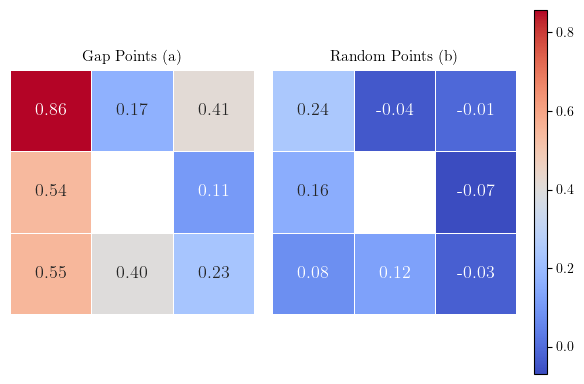

In [33]:
# Example usage
average_differences1 = calculate_average_differences(df_frost_gaps)
average_differences2 = calculate_average_difference_random(df_frost_random)
plot_average_differences_side_by_side(average_differences1, average_differences2)
plt.savefig('neighbours_difference_heatmaps.pdf')

In [34]:
def calculate_all_differences(df):
    # Ensure we work with a copy of the dataframe
    df_copy = df.copy()

    # Calculate the mean for each column
    mean_values = df_copy.mean(axis=0)

    # Initialize a dictionary to store the differences
    differences = {
        'left': [],
        'right': [],
        'above': [],
        'below': [],
        'top_left': [],
        'top_right': [],
        'bottom_left': [],
        'bottom_right': []
    }

    # Extract unique gap identifiers
    gaps = set(col.split('_')[0] for col in mean_values.index)

    # Calculate differences for each gap
    for gap in gaps:
        centre = mean_values[f'{gap}_centre']
        differences['left'].append(mean_values[f'{gap}_left'] - centre)
        differences['right'].append(mean_values[f'{gap}_right'] - centre)
        differences['above'].append(mean_values[f'{gap}_above'] - centre)
        differences['below'].append(mean_values[f'{gap}_below'] - centre)
        differences['top_left'].append(mean_values[f'{gap}_top_left'] - centre)
        differences['top_right'].append(mean_values[f'{gap}_top_right'] - centre)
        differences['bottom_left'].append(mean_values[f'{gap}_bottom_left'] - centre)
        differences['bottom_right'].append(mean_values[f'{gap}_bottom_right'] - centre)

    return differences

def calculate_all_differences_random(df):
    # Ensure we work with a copy of the dataframe
    df_copy = df.copy()

    # Calculate the mean for each column
    mean_values = df_copy.mean(axis=0)

    # Initialize a dictionary to store the differences
    differences = {
        'left': [],
        'right': [],
        'above': [],
        'below': [],
        'top_left': [],
        'top_right': [],
        'bottom_left': [],
        'bottom_right': []
    }

    # Extract unique gap identifiers and random points
    gaps = set(col.split('_')[0] for col in mean_values.index)
    random_points = set(col.split('_')[1] for col in mean_values.index)

    # Calculate differences for each gap and each random point set
    for gap in gaps:
        for rand in random_points:
            try:
                centre_key = f'{gap}_{rand}_centre'
                centre = mean_values[centre_key]
                for direction in ['left', 'right', 'above', 'below', 'top_left', 'top_right', 'bottom_left', 'bottom_right']:
                    key = f'{gap}_{rand}_{direction}'
                    differences[direction].append(mean_values[key] - centre)
            except KeyError as e:
                print(f'KeyError: {e}')
                continue

    return differences


In [404]:
gap_differences = calculate_all_differences(df_frost_gaps)
random_differences = calculate_all_differences_random(df_frost_random)

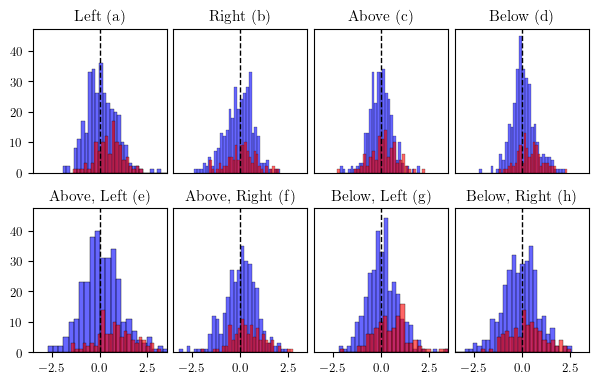

In [406]:

fig, axs = plt.subplots(2, 4, figsize=(6.15, 4), sharex=True, sharey=True)

# Function to plot histogram and set up axes
def plot_hist(ax, random_data, gap_data, title, show_x=False, show_y=False):
    sns.histplot(random_data, bins=30, color='blue', alpha=0.6, ax=ax, label='Random')
    sns.histplot(gap_data, bins=30, color='red', alpha=0.6, ax=ax, label='Gap')
    ax.set_title(title)
    
    # Remove y-axis label
    ax.set_ylabel('')
    
    # Set y-axis limit
    ax.set_xlim(-3.5, 3.5)
    
    # Enable grid
    #ax.grid(True)

    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

    
    # Keep all spines visible
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    # Set up x-axis
    ax.tick_params(axis='x', which='both', bottom=show_x, labelbottom=show_x)
    
    # Set up y-axis
    ax.tick_params(axis='y', which='both', left=show_y, labelleft=show_y)

# Plot histograms
plot_hist(axs[0, 0], random_differences['left'], gap_differences['left'], 'Left (a)', show_x=False, show_y=True)
plot_hist(axs[0, 1], random_differences['right'], gap_differences['right'], 'Right (b)', show_x=False, show_y=False)
plot_hist(axs[0, 2], random_differences['above'], gap_differences['above'], 'Above (c)', show_x=False, show_y=False)
plot_hist(axs[0, 3], random_differences['below'], gap_differences['below'], 'Below (d)', show_x=False, show_y=False)

plot_hist(axs[1, 0], random_differences['top_left'], gap_differences['top_left'], 'Above, Left (e)', show_x=True, show_y=True)
plot_hist(axs[1, 1], random_differences['top_right'], gap_differences['top_right'], 'Above, Right (f)', show_x=True, show_y=False)
plot_hist(axs[1, 2], random_differences['bottom_left'], gap_differences['bottom_left'], 'Below, Left (g)', show_x=True, show_y=False)
plot_hist(axs[1, 3], random_differences['bottom_right'], gap_differences['bottom_right'], 'Below, Right (h)', show_x=True, show_y=False)

# Add a legend to the figure
#fig.legend(['Random', 'Gap'], loc='upper right')

# Adjust the space between the plots
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.25)  # Adjust wspace and hspace as needed

plt.savefig('neighbours_distributions.pdf')

In [35]:
def extract_features(df, label):
    features = []
    for col in df.columns:
        series = df[col].dropna()  # Drop NaNs for feature calculation
        if not series.empty:
            mean_val = series.mean()
            var_val = series.var()
            skew_val = skew(series)
            max_val = series.max()
            min_val = series.min()
            range_val = max_val - min_val

            features.append({
                'name': col,
                'mean': mean_val,
                'variance': var_val,
                'skewness': skew_val,
                'max': max_val,
                'min': min_val,
                'range': range_val,
                'gap': label
            })

    return pd.DataFrame(features)

def create_feature_matrix(gap_df, random_df, area_df):
    # Make copies of the dataframes to avoid modifying the original ones
    gap_df = gap_df.copy()
    random_df = random_df.copy()
    area_df = area_df.copy()

    # Extract features for both dataframes
    gap_features = extract_features(gap_df, label=1)
    random_features = extract_features(random_df, label=0)

    # Add a zero-indexed row number to area_df
    area_df['row_index'] = area_df.index

    # Extract the numeric part of the 'name' column from gap_features
    gap_features['name_index'] = gap_features['name'].str.extract('(\d+)').astype(int)

    # Merge based on the row number
    gap_features = gap_features.merge(area_df[['row_index', 'area']], left_on='name_index', right_on='row_index', how='left')
    gap_features = gap_features.drop(columns=['row_index', 'name_index'])

    # Add area column to random_features with NaN values
    random_features['area'] = np.nan

    # Combine the features into a single DataFrame
    X_df = pd.concat([gap_features, random_features], ignore_index=True)

    return X_df


In [36]:
def rename_columns_offset_to_location(dfs):
    # Define the mappings from offset to location

    dfs=dfs.copy()

    offset_to_location = {
        '0,0': 'centre',
        '0,1': 'above',
        '0,-1': 'below',
        '-1,0': 'left',
        '1,0': 'right',
        '-1,1': 'top_left',
        '1,1': 'top_right',
        '-1,-1': 'bottom_left',
        '1,-1': 'bottom_right'
    }
    
    # Create a mapping for all column names
    new_columns = {}
    for col in dfs.columns:
        for offset, location in offset_to_location.items():
            if f'_{offset}' in col:
                new_columns[col] = col.replace(f'_{offset}', f'_{location}')
    
    # Rename the columns
    dfs = dfs.rename(columns=new_columns)
    return dfs


In [37]:
def extract_features(series, prefix):
    features = {
        f'{prefix}_mean': series.mean(),
        f'{prefix}_variance': series.var(),
        f'{prefix}_skewness': skew(series),
        f'{prefix}_max': series.max(),
        f'{prefix}_min': series.min(),
        f'{prefix}_range': series.max() - series.min()
    }
    return features

def extract_point_features(df, base_name):
    labels = ['centre', 'above', 'below', 'left', 'right', 'top_left', 'top_right', 'bottom_left', 'bottom_right']
    point_features = {}
    for label in labels:
        col_name = f'{base_name}_{label}'
        if col_name in df.columns:
            series = df[col_name].dropna()
            if not series.empty:
                point_features.update(extract_features(series, label))
    return point_features

def create_feature_matrix_v2(gap_df, random_df, area_df):
    # Rename columns to the new convention
    
    # Make copies of the dataframes to avoid modifying the original ones
    gap_df = gap_df.copy()
    random_df = random_df.copy()
    area_df = area_df.copy()

    # Initialize lists to collect features
    all_features = []

    # Process gap points
    for i in range(1, 108):  # 1 to 107 inclusive
        base_name = f'gap{i}'
        point_features = extract_point_features(gap_df, base_name)
        point_features['gap'] = 1
        point_features['area'] = area_df.loc[i-1, 'area'] if i-1 in area_df.index else np.nan
        all_features.append(point_features)

        # Process random points for each gap point
        for j in range(1, 4):  # 1 to 3 inclusive
            base_name_random = f'gap{i}_random{j}'
            random_point_features = extract_point_features(random_df, base_name_random)
            random_point_features['gap'] = 0
            random_point_features['area'] = np.nan
            all_features.append(random_point_features)

    # Create DataFrame from all features
    X_df = pd.DataFrame(all_features)

    return X_df

In [433]:
df_series_2yr_gaps = rename_columns_offset_to_location(df_series_2yr_gaps)
df_series_2yr_random = rename_columns_offset_to_location(df_series_2yr_random)

df_temporal_gaps = rename_columns_offset_to_location(df_temporal_gaps)
df_temporal_random = rename_columns_offset_to_location(df_temporal_random)

In [434]:
## NOW CREATE FEATURE DATAFRAMES AFTER FILTERED TIME SERIES HAVE BEEN CREATED

#X_df_alltime = create_feature_matrix(df_series_alltime_gaps, df_series_alltime_random, df)

X_df_2yr = create_feature_matrix_v2(df_series_2yr_gaps, df_series_2yr_random, df)

#X_df_2yr_reduced = create_feature_matrix(df_series_2yr_gaps,df_series_alltime_random_reduced, df)

X_df_2yr_frost = create_feature_matrix_v2(df_frost_gaps, df_frost_random,df)

X_df_2yr_lee = create_feature_matrix_v2(df_lee_gaps, df_lee_random,df)

X_df_2yr_temporal = create_feature_matrix_v2(df_temporal_gaps,df_temporal_random,df)

X_df_2yr_temporal_lee = create_feature_matrix_v2(df_temporal_lee_gaps, df_temporal_lee_random,df)

#X_df_2yr_lee_temporal = create_feature_matrix(df_lee_temporal_gaps,df_lee_temporal_random,df)

#X_df_2yr_frost_temporal = create_feature_matrix(df_)

X_df_2yr_temporal_frost = create_feature_matrix_v2(df_temporal_frost_gaps,df_temporal_frost_random,df)

X_df_2yr_quegan = create_feature_matrix_v2(df_quegan_gaps,df_quegan_random,df)

X_df_2yr_quegan_frost = create_feature_matrix_v2(df_quegan_frost_gaps, df_quegan_frost_random, df)

X_df_2yr_quegan3d = create_feature_matrix_v2(df_quegan3d_gaps, df_quegan3d_random, df)


### Save Datasets so I dont need to load them every time

In [574]:
feature_dataframes_list = [X_df_2yr, X_df_2yr_frost,X_df_2yr_lee,X_df_2yr_temporal_frost,X_df_2yr_temporal,X_df_2yr_temporal_lee,X_df_2yr_quegan,X_df_2yr_quegan_frost,X_df_2yr_quegan3d]

timeseries_dataframes_list = [[df_series_2yr_gaps,df_series_2yr_random],[df_frost_gaps, df_frost_random],[df_lee_gaps, df_lee_random],[df_temporal_gaps,df_temporal_random],[df_temporal_lee_gaps, df_temporal_lee_random],[df_temporal_frost_gaps,df_temporal_frost_random],[df_quegan_gaps,df_quegan_random],[df_quegan_frost_gaps, df_quegan_frost_random],[df_quegan3d_gaps, df_quegan3d_random]]

In [575]:
# Ensure the directory exists
save_directory = 'local_saved_datasets/feature_datasets/'
os.makedirs(save_directory, exist_ok=True)

# List of dataframe names as strings
dataframe_names = ['X_df_2yr', 'X_df_2yr_frost','X_df_2yr_lee','X_df_2yr_temporal_frost','X_df_2yr_temporal','X_df_2yr_temporal_lee','X_df_2yr_quegan','X_df_2yr_quegan_frost','X_df_2yr_quegan3d']

# Loop to save each dataframe
for df, name in zip(feature_dataframes_list, dataframe_names):
    save_path = os.path.join(save_directory, f"{name}.csv")
    df.to_csv(save_path, index=False)

print("Features DataFrames saved successfully!")


# Ensure the directory exists
save_directory = 'local_saved_datasets/timeseries_datasets/'
os.makedirs(save_directory, exist_ok=True)


# List of names corresponding to the dataframes
timeseries_names_list = [['df_series_2yr_gaps', 'df_series_2yr_random'],['df_frost_gaps', 'df_frost_random'],['df_lee_gaps', 'df_lee_random'],['df_temporal_gaps', 'df_temporal_random'],
['df_temporal_lee_gaps', 'df_temporal_lee_random'],['df_temporal_frost_gaps', 'df_temporal_frost_random'],['df_quegan_gaps', 'df_quegan_random'],['df_quegan_frost_gaps', 'df_quegan_frost_random'],
['df_quegan3d_gaps', 'df_quegan3d_random']]

# Loop to save each dataframe
for df_pair, name_pair in zip(timeseries_dataframes_list, timeseries_names_list):
    for df, name in zip(df_pair, name_pair):
        save_path = os.path.join(save_directory, f"{name}.csv")
        df.to_csv(save_path, index=False)

print("Time series DataFrames saved successfully!")


Features DataFrames saved successfully!
Time series DataFrames saved successfully!


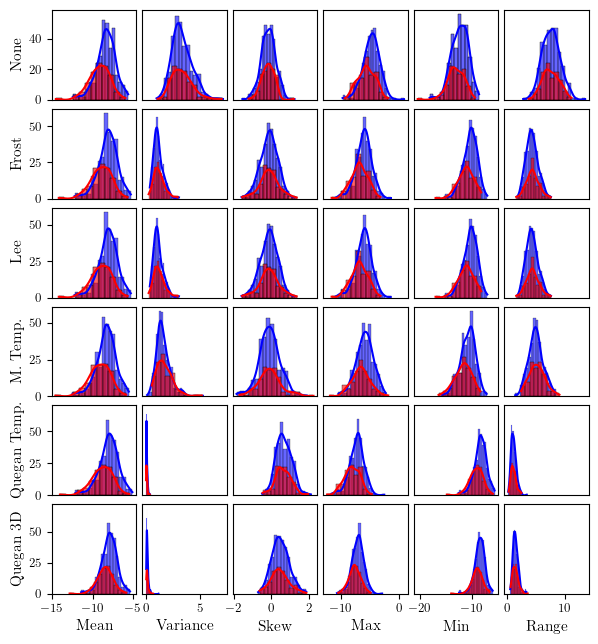

In [337]:
def plot_feature_distributions_strip(dfs, y_labels):
    # Select the columns to plot
    features = ['mean', 'variance', 'skewness', 'max', 'min', 'range']
    
    # Define the custom color palette
    palette = {0: 'blue', 1: 'red'}
    
    # Define the custom labels for the x-axis
    x_labels = {
        'mean': 'Mean',
        'variance': 'Variance',
        'skewness': 'Skew',
        'max': 'Max',
        'min': 'Min',
        'range': 'Range'
    }
    
    # Create a figure with subplots
    num_dfs = len(dfs)
    fig, axes = plt.subplots(num_dfs, len(features), figsize=(6.15, 1.1 * num_dfs), sharex='col', sharey='row')
    
    # Plot histograms for each feature in each dataframe
    for row, (df__, y_label) in enumerate(zip(dfs, y_labels)):
        for col, feature in enumerate(features):
            sns.histplot(data=df__[df__['gap'] == 0], x=feature, kde=True, ax=axes[row, col], color='blue', alpha=0.6, label='0')
            sns.histplot(data=df__[df__['gap'] == 1], x=feature, kde=True, ax=axes[row, col], color='red', alpha=0.6, label='1')
            
            if row == num_dfs - 1:
                axes[row, col].set_xlabel(x_labels[feature])  # Set the custom x-axis label for the bottom row
                axes[row, col].tick_params(axis='x', which='both', bottom=True)  # Show x-ticks only on the bottom row
            else:
                axes[row, col].set_xlabel('')
                axes[row, col].tick_params(axis='x', which='both', bottom=False)  # Hide x-ticks on other rows
            
            if col == 0:
                axes[row, col].set_ylabel(y_label)  # Set the custom y-axis label for each row
                axes[row, col].tick_params(axis='y', which='both', left=True)  # Show y-ticks only on the leftmost column
            else:
                axes[row, col].set_ylabel('')
                axes[row, col].tick_params(axis='y', which='both', left=False)  # Hide y-ticks on other columns

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.07, hspace=0.1)  # Adjust the space between the plots

# Example usage:
# Assuming your DataFrames are named X_df_2yr, X_df_2yr_frost, X_df_2yr_lee, X_df_2yr_temporal, X_df_2yr_quegan, and X_df_2yr_quegan3d
X_df_2yr_list = [X_df_2yr, X_df_2yr_frost, X_df_2yr_lee, X_df_2yr_temporal, X_df_2yr_quegan, X_df_2yr_quegan3d]
y_labels = ['None', 'Frost', 'Lee', 'M. Temp.', 'Quegan Temp.', 'Quegan 3D']
plot_feature_distributions_strip(X_df_2yr_list, y_labels)
plt.savefig('distribution_strip.pdf')

In [228]:
def mean_var_axis1(df):

    '''
    calculate mean and variance for each date
    effectively the 'average' time series
    '''

    mean=df.mean(axis=1)
    variance=df.var(axis=1)

    return(mean,variance)


def mean_var_axis0(df):
    
    '''
    calculates mean and variance for each time series
    acts down columns
    '''

    mean=df.mean(axis=0)
    variance=df.var(axis=0)

    return(mean,variance)


def aggregate_and_ensemble_vals(df):
    
    ### calculate 'average' time series
    m1,v1=mean_var_axis0(df)
    ensemble_mean=np.mean(m1)
    ensemble_var=np.var(m1)

    ### calculate mean of each time series
    m2,v2=mean_var_axis1(df)
    aggregate_mean=np.mean(m2)
    aggregate_var=np.var(m2)

    return((ensemble_mean,ensemble_var),(aggregate_mean,aggregate_var))

In [42]:
df_series_2yr_random1 = pd.DataFrame()
df_series_2yr_random2 = pd.DataFrame()
df_series_2yr_random3 = pd.DataFrame()

df_series_2yr_random1_frost = pd.DataFrame()
df_series_2yr_random2_frost = pd.DataFrame()
df_series_2yr_random3_frost = pd.DataFrame()

df_series_2yr_random1_lee = pd.DataFrame()
df_series_2yr_random2_lee = pd.DataFrame()
df_series_2yr_random3_lee = pd.DataFrame()

df_series_2yr_random1_temporal = pd.DataFrame()
df_series_2yr_random2_temporal = pd.DataFrame()
df_series_2yr_random3_temporal = pd.DataFrame()

df_series_2yr_random1_temporal_lee = pd.DataFrame()
df_series_2yr_random2_temporal_lee = pd.DataFrame()
df_series_2yr_random3_temporal_lee = pd.DataFrame()

df_series_2yr_random1_temporal_frost = pd.DataFrame()
df_series_2yr_random2_temporal_frost = pd.DataFrame()
df_series_2yr_random3_temporal_frost = pd.DataFrame()

df_series_2yr_random1_quegan = pd.DataFrame()
df_series_2yr_random2_quegan = pd.DataFrame()
df_series_2yr_random3_quegan = pd.DataFrame()

df_series_2yr_random1_quegan_frost = pd.DataFrame()
df_series_2yr_random2_quegan_frost = pd.DataFrame()
df_series_2yr_random3_quegan_frost = pd.DataFrame()

df_series_2yr_random1_quegan3d = pd.DataFrame()
df_series_2yr_random2_quegan3d = pd.DataFrame()
df_series_2yr_random3_quegan3d = pd.DataFrame()


# Separate columns based on their suffix (random1, random2, random3)
for col in df_series_2yr_random_for_filter_comparison.columns:
    if col.endswith('_random1'):
        df_series_2yr_random1[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2'):
        df_series_2yr_random2[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3'):
        df_series_2yr_random3[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Separate columns based on their suffix (random1, random2, random3)
for col in df_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Separate columns based on their suffix (random1, random2, random3)
for col in df_lee_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_random.columns:
    if col.endswith('_random1'):
        df_series_2yr_random1_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2'):
        df_series_2yr_random2_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3'):
        df_series_2yr_random3_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_lee_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_temporal_frost[col] = df_temporal_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_temporal_frost[col] = df_temporal_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_temporal_frost[col] = df_temporal_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_quegan_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_quegan[col] = df_quegan_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_quegan[col] = df_quegan_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_quegan[col] = df_quegan_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_quegan_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_quegan_frost[col] = df_quegan_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_quegan_frost[col] = df_quegan_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_quegan_frost[col] = df_quegan_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_quegan3d_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_quegan3d[col] = df_quegan3d_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_quegan3d[col] = df_quegan3d_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_quegan3d[col] = df_quegan3d_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [44]:
#alltime_dfs = [df_series_alltime_gaps, [df_series_alltime_random1, df_series_alltime_random2, df_series_alltime_random3]]
_2yr_dfs = [df_series_2yr_gaps, [df_series_2yr_random1,df_series_2yr_random2,df_series_2yr_random3]]

_2yr_dfs_frost = [df_frost_gaps, [df_series_2yr_random1_frost,df_series_2yr_random2_frost,df_series_2yr_random3_frost]]
_2yr_dfs_lee = [df_lee_gaps, [df_series_2yr_random1_lee,df_series_2yr_random2_lee,df_series_2yr_random3_lee]]
_2yr_dfs_temporal = [df_temporal_gaps, [df_series_2yr_random1_temporal,df_series_2yr_random2_temporal,df_series_2yr_random3_temporal]]
_2yr_dfs_temporal_lee = [df_temporal_lee_gaps, [df_series_2yr_random1_temporal_lee,df_series_2yr_random2_temporal_lee,df_series_2yr_random3_temporal_lee]]
_2yr_dfs_temporal_frost = [df_temporal_frost_gaps, [df_series_2yr_random1_temporal_frost,df_series_2yr_random2_temporal_frost,df_series_2yr_random3_temporal_frost]]
_2yr_dfs_quegan = [df_quegan_gaps, [df_series_2yr_random1_quegan,df_series_2yr_random2_quegan,df_series_2yr_random3_quegan]]
_2yr_dfs_temporal_quegan = [df_quegan_frost_gaps, [df_series_2yr_random1_quegan_frost,df_series_2yr_random2_quegan_frost,df_series_2yr_random3_quegan_frost]]
_2yr_dfs_quegan3d = [df_quegan3d_gaps, [df_series_2yr_random1_quegan3d,df_series_2yr_random2_quegan3d,df_series_2yr_random3_quegan3d]]

In [45]:
def extract_variances(dfs):
    variances = []
    for df in dfs:
        _, variance = mean_var_axis0(df)
        variances.append(variance)
    return variances

def plot_boxplots(alltime_dfs, _2yr_dfs):
    # Extract variances for each set of dataframes
    variances_alltime = extract_variances([alltime_dfs[0]] + alltime_dfs[1])
    variances_2yr = extract_variances([_2yr_dfs[0]] + _2yr_dfs[1])
    
    # Combine all variances for plotting
    data_alltime = variances_alltime
    data_2yr = variances_2yr

    # Labels for the boxplots
    labels_alltime = ['Gap', 'Random 1', 'Random 2', 'Random 3']
    labels_2yr = ['Gap', 'Random 1', 'Random 2', 'Random 3']

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

    # Boxplot properties
    boxprops = dict(facecolor='blue', color='black')
    medianprops = dict(color='red', linewidth=2)
    whiskerprops = dict(color='black', linewidth=2)
    capprops = dict(color='black', linewidth=2)
    flierprops = dict(marker='o', color='blue', alpha=0.5)
    
    # Boxplot for Alltime dataframes
    bp_alltime = axs[0].boxplot(data_alltime, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, showmeans=True)
    axs[0].set_xticklabels(labels_alltime, rotation=45)
    axs[0].set_ylabel('Variance')
    axs[0].set_title('(a)')
    axs[0].grid(True)

    # Boxplot for 2-Year dataframes
    bp_2yr = axs[1].boxplot(data_2yr, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, showmeans=True)
    axs[1].set_xticklabels(labels_2yr, rotation=45)
    axs[1].set_title('(b)')
    axs[1].grid(True)

    # Customize the mean points
    for mean in bp_alltime['means']:
        mean.set(marker='o', color='red', markersize=7)
    for mean in bp_2yr['means']:
        mean.set(marker='o', color='red', markersize=7)

    plt.tight_layout()

#plot_boxplots(alltime_dfs, _2yr_dfs)
#plt.savefig('boxplot_variance.pdf')

In [46]:
def plot_side_by_side(dfs1, dfs2, dfs3, labels1, labels2, labels3):
    fig, axs = plt.subplots(1, 3, figsize=(6, 3), sharex=True, sharey=True)

    # Initialize lists to hold all the scatter points for x and y
    all_x = []
    all_y = []

    def plot_scatter(ax, gap_df, random_dfs, color_gap, color_random):
        (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(gap_df)
        all_x.extend([ensemble_mean, aggregate_mean])
        all_y.extend([ensemble_var, aggregate_var])
        ax.scatter(ensemble_mean, ensemble_var, color=color_gap, marker='x', s=100, label='Gap - Ensemble')
        ax.scatter(aggregate_mean, aggregate_var, color=color_gap, marker='x', s=50, label='Gap - Aggregate')
        for df in random_dfs:
            (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(df)
            all_x.extend([ensemble_mean, aggregate_mean])
            all_y.extend([ensemble_var, aggregate_var])
            ax.scatter(ensemble_mean, ensemble_var, color=color_random, marker='o', s=100, label='Random - Ensemble', alpha=0.5)
            ax.scatter(aggregate_mean, aggregate_var, color=color_random, marker='o', s=25, label='Random - Aggregate', alpha=0.5)

    # Plot for the first set of dataframes (Alltime)
    gap_df1, random_dfs1 = dfs1
    print(type(gap_df1),type(random_dfs1))
    plot_scatter(axs[0], gap_df1, random_dfs1, 'red', 'blue')
    axs[0].set_title(labels1)
    axs[0].set_xlabel('Mean')
    axs[0].set_ylabel('Variance')
    axs[0].grid()

    # Plot for the second set of dataframes (2-Year)
    gap_df2, random_dfs2 = dfs2
    plot_scatter(axs[1], gap_df2, random_dfs2, 'red', 'blue')
    axs[1].set_title(labels2)
    axs[1].set_xlabel('Mean')
    axs[1].grid()

    # Plot for the third set of dataframes (Third set)
    gap_df3, random_dfs3 = dfs3
    plot_scatter(axs[2], gap_df3, random_dfs3, 'red', 'blue')
    axs[2].set_title(labels3)
    axs[2].set_xlabel('Mean')
    axs[2].grid()

    # Compute the min and max for x and y with a 0.2 border
    x_min, x_max = min(all_x) - 0.3, max(all_x) + 0.3
    y_min, y_max = min(all_y) - 0.3, max(all_y) + 0.3

    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Custom legend
    handles = [
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Ensemble', markerfacecolor='none', markeredgecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Aggregate', markerfacecolor='none', markeredgecolor='red', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Ensemble', markerfacecolor='blue', markeredgecolor='blue', markersize=12, alpha=0.5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Aggregate', markerfacecolor='blue', markeredgecolor='blue', markersize=5, alpha=0.5)
    ]
    #fig.legend(handles=handles, loc='upper center', ncol=1, bbox_to_anchor=(0.55, 1.28))

    plt.tight_layout()

# Plotting the scatter plots
#labels_alltime = 'No filter (a)'
#labels_2yr = 'Frost Filter (b)'
#labels_3rd = 'Temp Lee Filter (c)'
#plot_side_by_side(_2yr_dfs, _2yr_dfs_frost, _2yr_dfs_quegan, labels_alltime, labels_2yr, labels_3rd)
#plt.savefig('filter_3_comparison.pdf')
#plt.show()

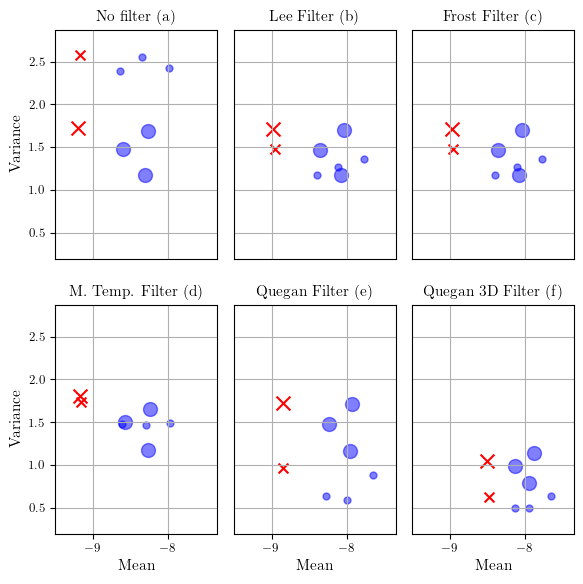

In [342]:
def plot_side_by_side_6(dfs1, dfs2, dfs3, dfs4, dfs5, dfs6, labels1, labels2, labels3, labels4, labels5, labels6):
    fig, axs = plt.subplots(2, 3, figsize=(6, 6), sharex=True, sharey=True)

    # Initialize lists to hold all the scatter points for x and y
    all_x = []
    all_y = []

    def plot_scatter(ax, gap_df, random_dfs, color_gap, color_random):
        (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(gap_df)
        all_x.extend([ensemble_mean, aggregate_mean])
        all_y.extend([ensemble_var, aggregate_var])
        ax.scatter(ensemble_mean, ensemble_var, color=color_gap, marker='x', s=100, label='Gap - Ensemble')
        ax.scatter(aggregate_mean, aggregate_var, color=color_gap, marker='x', s=50, label='Gap - Aggregate')
        for df in random_dfs:
            (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(df)
            all_x.extend([ensemble_mean, aggregate_mean])
            all_y.extend([ensemble_var, aggregate_var])
            ax.scatter(ensemble_mean, ensemble_var, color=color_random, marker='o', s=100, label='Random - Ensemble', alpha=0.5)
            ax.scatter(aggregate_mean, aggregate_var, color=color_random, marker='o', s=25, label='Random - Aggregate', alpha=0.5)

    # List of dataframes and labels
    dataframe_list = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs6]
    labels_list = [labels1, labels2, labels3, labels4, labels5, labels6]

    # Plot for each set of dataframes
    for idx, (dfs, label) in enumerate(zip(dataframe_list, labels_list)):
        row, col = divmod(idx, 3)
        gap_df, random_dfs = dfs
        plot_scatter(axs[row, col], gap_df, random_dfs, 'red', 'blue')
        axs[row, col].set_title(label)
        if row == 1:
            axs[row, col].set_xlabel('Mean')
        else:
            axs[row, col].set_xlabel('')
            axs[row, col].tick_params(axis='x', which='both', bottom=False)
        if col == 0:
            axs[row, col].set_ylabel('Variance')
        else:
            axs[row, col].set_ylabel('')
            axs[row, col].tick_params(axis='y', which='both', left=False)
        axs[row, col].grid()

    # Compute the min and max for x and y with a 0.3 border
    x_min, x_max = min(all_x) - 0.3, max(all_x) + 0.3
    y_min, y_max = min(all_y) - 0.3, max(all_y) + 0.3

    for ax in axs.flat:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Custom legend
    handles = [
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Ensemble', markerfacecolor='none', markeredgecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Aggregate', markerfacecolor='none', markeredgecolor='red', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Ensemble', markerfacecolor='blue', markeredgecolor='blue', markersize=12, alpha=0.5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Aggregate', markerfacecolor='blue', markeredgecolor='blue', markersize=5, alpha=0.5)
    ]
    #fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Example usage:
# Assuming your DataFrames are named as follows

labels1 = 'No filter (a)'
labels2 = 'Lee Filter (b)'
labels3 = 'Frost Filter (c)'
labels4 = 'M. Temp. Filter (d)'
labels5 = 'Quegan Filter (e)'
labels6 = 'Quegan 3D Filter (f)'


plot_side_by_side_6(_2yr_dfs, _2yr_dfs_lee, _2yr_dfs_frost,_2yr_dfs_temporal,_2yr_dfs_quegan,_2yr_dfs_quegan3d, labels1,labels2,labels3,labels4, labels5, labels6)
plt.savefig('filter_6_comparison_scatter.pdf')
plt.show()


In [437]:
## REMOVE AREA COLUMN FROM FEATURE DATAFRAMES SO WE CAN PLOT
# only area is removed since its numerical, but areas are only present for gap datapoints, not random ones

X_df_2yr_clean=X_df_2yr.drop(columns=['area'],axis=1)
X_df_2yr_frost_clean=X_df_2yr_frost.drop(columns=['area'],axis=1)
X_df_2yr_lee_clean = X_df_2yr_lee.drop(columns=['area'],axis=1)
X_df_2yr_temporal_clean = X_df_2yr_temporal.drop(columns=['area'],axis=1)
X_df_2yr_temporal_frost_clean = X_df_2yr_temporal_frost.drop(columns=['area'],axis=1)
X_df_2yr_temporal_lee_clean=X_df_2yr_temporal_lee.drop(columns=['area'],axis=1)
X_df_2yr_quegan_clean=X_df_2yr_quegan.drop(columns=['area'],axis=1)
X_df_2yr_quegan_frost_clean=X_df_2yr_quegan_frost.drop(columns=['area'],axis=1)
X_df_2yr_quegan3d_clean=X_df_2yr_quegan3d.drop(columns=['area'],axis=1)

In [234]:
def dunn_index(X, labels):
    """
    Dunn index as the ratio of the minimum inter-cluster distance to the maximum intra-cluster distance.
    
    - High Dunn Index:  well-separated and compact clusters (good).
    - Low Dunn Index:  poorly separated and dispersed clusters (bad).
    
    Args:
        X (np.ndarray): Data points.
        labels (np.ndarray): Cluster labels for each data point.

    Returns:
        float: The Dunn Index score.
    """
    distances = squareform(pdist(X))
    unique_labels = np.unique(labels)
    
    intra_cluster_dists = []
    inter_cluster_dists = []
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            intra_cluster_dists.append(np.mean(pdist(cluster_points)))
        for other_label in unique_labels:
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                inter_cluster_dists.append(np.min([np.linalg.norm(a - b) for a in cluster_points for b in other_cluster_points]))
                
    return np.min(inter_cluster_dists) / np.max(intra_cluster_dists)

def calculate_cluster_metrics(feature_matrix):
    """
    Calculate clustering metrics for a given feature matrix.

    This function computes the Silhouette Score, Davies-Bouldin Index, and Dunn Index to evaluate the quality of clustering.

    - Silhouette Score:
        - High Silhouette Score: Indicates well-separated clusters (good).
        - Low Silhouette Score: Indicates overlapping clusters (bad).
    - Davies-Bouldin Index:
        - Low Davies-Bouldin Index: Indicates well-separated and compact clusters (good).
        - High Davies-Bouldin Index: Indicates poorly separated and dispersed clusters (bad).
    - Dunn Index:
        - High Dunn Index: Indicates well-separated and compact clusters (good).
        - Low Dunn Index: Indicates poorly separated and dispersed clusters (bad).
    
    Args:
        feature_matrix (pd.DataFrame): DataFrame containing feature values and cluster labels.

    Returns:
        tuple: Silhouette Score, Davies-Bouldin Index, Dunn Index.
    """
    X = feature_matrix.drop(columns=['name', 'gap'])
    labels = feature_matrix['gap']

    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    dunn = dunn_index(X.values, labels.values)
    
    return silhouette, davies_bouldin, dunn


In [248]:
dataframes_list = [
    "X_df_2yr_clean", "X_df_2yr_frost_clean", "X_df_2yr_lee_clean", "X_df_2yr_temporal_clean",
    "X_df_2yr_temporal_lee_clean", "X_df_2yr_temporal_frost_clean", "X_df_2yr_quegan_clean","X_df_2yr_quegan3d_clean"
]

# Dictionary to store the results
results = {}

# Loop through each dataframe, calculate metrics and store the results
for df_name in dataframes_list:
    feature_df = globals()[df_name]
    silhouette, davies_bouldin, dunn = calculate_cluster_metrics(feature_df)
    results[df_name] = [silhouette, davies_bouldin, dunn]

# Create a dataframe from the results dictionary
metrics_df = pd.DataFrame(results, index=["Silhouette Score", "Davies-Bouldin Index", "Dunn Index"])

metrics_df.T

,Silhouette Score,Davies-Bouldin Index,Dunn Index
X_df_2yr_clean,0.037660,4.023448,0.005129
X_df_2yr_frost_clean,0.071455,3.335808,0.000614
X_df_2yr_lee_clean,0.071488,3.336063,0.000614
X_df_2yr_temporal_clean,0.060745,3.915573,0.000000
X_df_2yr_temporal_lee_clean,0.071471,3.409666,0.000000
X_df_2yr_temporal_frost_clean,0.071448,3.409334,0.000000
X_df_2yr_quegan_clean,0.083675,2.699308,0.002918
X_df_2yr_quegan3d_clean,0.048229,3.512939,0.003354


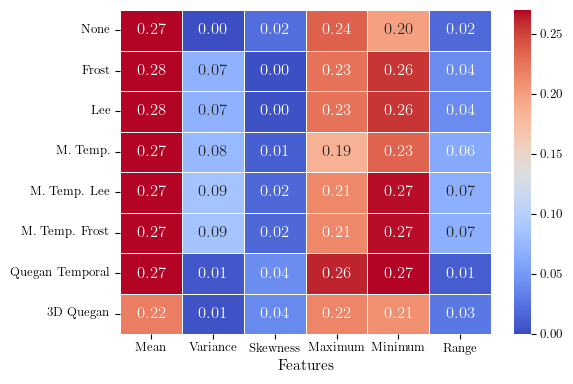

In [247]:
dataframes_list = [
    "X_df_2yr_clean", "X_df_2yr_frost_clean", "X_df_2yr_lee_clean", "X_df_2yr_temporal_clean",
    "X_df_2yr_temporal_lee_clean", "X_df_2yr_temporal_frost_clean", "X_df_2yr_quegan_clean","X_df_2yr_quegan3d_clean"
]

correlation_results = {}

# Loop through each DataFrame and calculate the absolute correlation with 'gap'
for df_name in dataframes_list:
    df = globals()[df_name]
    numeric_features = df.drop(columns=['name'])
    correlation_matrix = numeric_features.corr()
    gap_correlations = correlation_matrix.loc['gap'].drop('gap').abs()  # Taking the absolute value
    correlation_results[df_name] = gap_correlations

correlation_df = pd.DataFrame(correlation_results).T

# Define label mappings
df_label_mapping = {
    "X_df_2yr_clean": "None",
    "X_df_2yr_frost_clean": "Frost",
    "X_df_2yr_lee_clean": "Lee",
    "X_df_2yr_temporal_clean": "M. Temp.",
    "X_df_2yr_temporal_lee_clean": "M. Temp. Lee",
    "X_df_2yr_temporal_frost_clean": "M. Temp. Frost",
    "X_df_2yr_quegan_clean": "Quegan Temporal",
    "X_df_2yr_quegan3d_clean":'3D Quegan',
}

# Replace DataFrame labels
correlation_df.index = correlation_df.index.map(df_label_mapping)

# Replace feature names if needed (example feature mapping)
feature_label_mapping = {
    "mean": "Mean",
    "variance": "Variance",
    "skewness": "Skewness",
    "max": "Maximum",
    "min": "Minimum",
    "range": "Range"
}

correlation_df.columns = correlation_df.columns.map(feature_label_mapping)

# Plot the correlation summary table with absolute values
plt.figure(figsize=(6.1, 4))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5, vmin=0, vmax=0.27)
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('correlation_table.pdf')
plt.show()


In [327]:
def plot_top_to_bottom_scatter(X_df1, X_df2, title1, title2):
    # Create a figure with two subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True,sharey=True)
    
    # Plot for the first dataframe
    gap_points1 = X_df1[X_df1['gap'] == 1]
    non_gap_points1 = X_df1[X_df1['gap'] == 0]
    
    ax1.scatter(non_gap_points1['mean'], non_gap_points1['variance'], color='blue', marker='o', label='Random',s=20)
    ax1.scatter(gap_points1['mean'], gap_points1['variance'], color='red', marker='x', label='Gap',s=25)
    ax1.set_ylabel('Variance')
    ax1.legend(loc = 'upper left')
    ax1.grid(True)
    ax1.text(1.02, 0.5, '(a)', transform=ax1.transAxes, verticalalignment='center', fontweight='bold')


    # Plot for the second dataframe
    gap_points2 = X_df2[X_df2['gap'] == 1]
    non_gap_points2 = X_df2[X_df2['gap'] == 0]

    ax2.scatter(non_gap_points2['mean'], non_gap_points2['variance'], color='blue', marker='o', label='Random',s=20)
    ax2.scatter(gap_points2['mean'], gap_points2['variance'], color='red', marker='x', label='Gap',s=25)
    ax2.set_xlabel('Mean')
    ax2.set_ylabel('Variance')
    ax2.legend(loc = 'upper left')
    ax2.grid(True)
    ax2.text(1.02, 0.5, '(b)', transform=ax2.transAxes, verticalalignment='center', fontweight='bold')

    
    plt.tight_layout()

# Example usage
#plot_top_to_bottom_scatter(X_df_2yr, X_df_2yr_frost, 'All Time Data', '2 Year Data')
#plt.savefig('allscatter_double.pdf')

In [328]:
def perform_pca_and_plot_combined(X_df1, title1, X_df2, title2, X_df3, title3):
    # Define a helper function to perform PCA and return principal components and explained variance
    def perform_pca(X_df):
        features = X_df.drop(columns=['name', 'gap', 'area'], errors='ignore')
        pca = PCA(n_components=min(len(features.columns), 6))  # Adjust n_components to the number of features or 6
        principal_components = pca.fit_transform(features.fillna(0))  # Fill NaN with 0 for PCA
        pca_df = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(pca.n_components_)])
        pca_df['gap'] = X_df['gap']
        explained_variance = pca.explained_variance_ratio_
        return pca_df, explained_variance

    # Perform PCA on the three datasets
    pca_df1, explained_variance1 = perform_pca(X_df1)
    pca_df2, explained_variance2 = perform_pca(X_df2)
    pca_df3, explained_variance3 = perform_pca(X_df3)

    # Plot the PCA results side by side
    fig, axes = plt.subplots(2, 2, figsize=(6.1, 6.1))

    # Plot for the first dataset
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df1[pca_df1['gap'] == 0],
                    palette={0: 'blue'}, style='gap', markers={0: 'o'}, ax=axes[0, 0], zorder=1)
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df1[pca_df1['gap'] == 1],
                    palette={1: 'red'}, style='gap', markers={1: 'X'}, ax=axes[0, 0], zorder=2)
    axes[0, 0].set_xlim(-6.5, 11)
    axes[0, 0].set_ylim(-5, 8)
    axes[0, 0].grid(True)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_xticklabels([])
    axes[0, 0].tick_params(axis='x', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[0,0].set_title(f'(a) {title1}')
    axes[0, 0].get_legend().remove()

    # Plot for the second dataset
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df2[pca_df2['gap'] == 0],
                    palette={0: 'blue'}, style='gap', markers={0: 'o'}, ax=axes[0, 1], zorder=1)
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df2[pca_df2['gap'] == 1],
                    palette={1: 'red'}, style='gap', markers={1: 'X'}, ax=axes[0, 1], zorder=2)
    axes[0, 1].set_xlim(-6.5, 11)
    axes[0, 1].set_ylim(-5, 8)
    axes[0, 1].set_ylabel('')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_xticklabels([])
    axes[0, 1].set_yticklabels([])
    axes[0, 1].grid(True)
    axes[0, 1].tick_params(axis='x', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[0, 1].tick_params(axis='y', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[0,1].set_title(f'(b) {title2}')
    axes[0, 1].get_legend().remove()

    # Plot for the third dataset in the bottom right position (axes[1, 1])
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df3[pca_df3['gap'] == 0],
                    palette={0: 'blue'}, style='gap', markers={0: 'o'}, ax=axes[1, 1], zorder=1)
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df3[pca_df3['gap'] == 1],
                    palette={1: 'red'}, style='gap', markers={1: 'X'}, ax=axes[1, 1], zorder=2)
    axes[1, 1].set_xlim(-6.5, 11)
    axes[1, 1].set_ylim(-5, 8)
    axes[1, 1].grid(True)
    axes[1,1].set_ylabel('')
    axes[1, 1].set_yticklabels([])
    axes[1, 1].tick_params(axis='y', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[1,1].set_title(f'(c) {title3}')
    red_marker = mlines.Line2D([], [], color='red', marker='x', linestyle='None', markersize=7, label='Tree Gap')
    blue_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=7, label='Random Point')

# Add the custom legend to axes[1, 1]
    axes[1, 1].legend(handles=[red_marker, blue_marker], loc='best', title='')

    # Plot the scree plot with explained variance in the bottom left position (axes[1, 0])
    ax_scree = fig.add_subplot(2, 2, 3)  # Changing from (2, 2, 4) to (2, 2, 3)
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])
    components = range(1, len(explained_variance1) + 1)
    ax_scree.plot(components, explained_variance1, marker='o', markersize=4, label=title1, color='#3a86ff')
    ax_scree.plot(components, explained_variance2, marker='x', markersize=4, label=title2, color='#ff006e')
    ax_scree.plot(components, explained_variance3, marker='s', markersize=4, label=title3, color='#ffbe0b')
    ax_scree.set_xlabel('Principal Components')
    ax_scree.set_ylabel('Explained Variance')
    ax_scree.legend(title='Filter')
    ax_scree.grid(True)
    ax_scree.set_title('(d) Scree Plot')


    plt.tight_layout()

# Example usage
#perform_pca_and_plot_combined(X_df_2yr_clean, 'None', X_df_2yr_temporal_lee_clean, 'Temporal Lee', X_df_2yr_quegan_clean, 'Quegan Temporal')
#plt.savefig('pca_filter_plots.pdf')


### Other Metrics

In [24]:
def calculate_mean_variance(time_series):
    """
    Calculate the mean and variance of a given time series.

    Parameters:
    time_series (list): The input time series data.

    Returns:
    tuple: A tuple containing the mean and variance of the time series.
    """
    n = len(time_series)
    mean = sum(time_series) / n
    variance = sum((x - mean) ** 2 for x in time_series) / (n - 1)
    
    return mean, variance

# Example usage:
time_series_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean, variance = calculate_mean_variance(time_series_data)

In [31]:
X_df_prime=X_df.sort_values(by='area',ascending=False).iloc[1:]

In [37]:
below_100 = X_df[X_df['area'] < 39].shape[0]

# Count the number of entries with area 100 and above
above_100 = X_df[X_df['area'] >= 100].shape[0]

below_100, above_100

(1, 90)

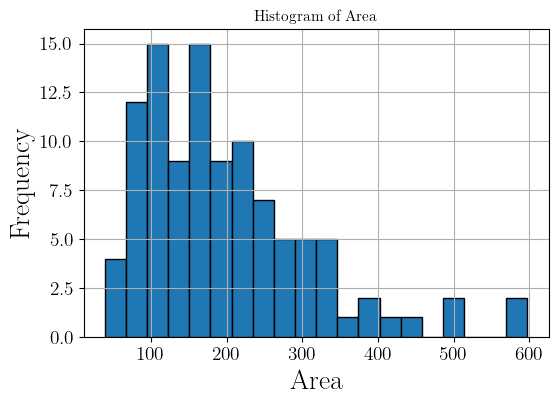

In [32]:
plt.figure(figsize=(6, 4))
plt.hist(X_df_prime['area'], bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# CREATING MODEL

### load in data from saved csv files

In [ ]:
# Directories where the CSV files are stored
feature_directory = 'local_saved_datasets/feature_datasets/'
timeseries_directory = 'local_saved_datasets/timeseries_datasets/'

# Loading feature dataframes
feature_dataframes_list = []
for name in dataframe_names:
    filepath = os.path.join(feature_directory, f"{name}.csv")
    df = pd.read_csv(filepath)
    feature_dataframes_list.append(df)

# Loading timeseries dataframes
timeseries_dataframes_list = []
for names_pair in timeseries_names_list:
    df_pair = []
    for name in names_pair:
        filepath = os.path.join(timeseries_directory, f"{name}.csv")
        df = pd.read_csv(filepath)
        df_pair.append(df)
    timeseries_dataframes_list.append(df_pair)

print("DataFrames loaded successfully!")


In [ ]:
X_df_2yr_clean=X_df_2yr.drop(columns=['area'],axis=1)
X_df_2yr_frost_clean=X_df_2yr_frost.drop(columns=['area'],axis=1)
X_df_2yr_lee_clean = X_df_2yr_lee.drop(columns=['area'],axis=1)
X_df_2yr_temporal_clean = X_df_2yr_temporal.drop(columns=['area'],axis=1)
X_df_2yr_temporal_frost_clean = X_df_2yr_temporal_frost.drop(columns=['area'],axis=1)
X_df_2yr_temporal_lee_clean=X_df_2yr_temporal_lee.drop(columns=['area'],axis=1)
X_df_2yr_quegan_clean=X_df_2yr_quegan.drop(columns=['area'],axis=1)
X_df_2yr_quegan_frost_clean=X_df_2yr_quegan_frost.drop(columns=['area'],axis=1)
X_df_2yr_quegan3d_clean=X_df_2yr_quegan3d.drop(columns=['area'],axis=1)

In [439]:
#feature_dataframes_list = [X_df_2yr_clean, X_df_2yr_frost_clean,X_df_2yr_lee_clean,X_df_2yr_temporal_frost_clean,X_df_2yr_temporal_clean,X_df_2yr_temporal_lee_clean,X_df_2yr_quegan_clean,X_df_2yr_quegan_frost_clean,X_df_2yr_quegan3d_clean]

#timeseries_dataframes_list = [[df_series_2yr_gaps,df_series_2yr_random],[df_frost_gaps, df_frost_random],[df_lee_gaps, df_lee_random],[df_temporal_gaps,df_temporal_random],[df_temporal_lee_gaps, df_temporal_lee_random],[df_temporal_frost_gaps,df_temporal_frost_random],[df_quegan_gaps,df_quegan_random],[df_quegan_frost_gaps, df_quegan_frost_random],[df_quegan3d_gaps, df_quegan3d_random]]

In [64]:
def train_random_forest_and_plot_roc(df):
    # Separate features and target variable
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train the random forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

parameters: 0.0009765625
parameters: 0.001953125
parameters: 0.0029296875
parameters: 0.00390625
parameters: 0.0048828125
parameters: 0.005859375
parameters: 0.0068359375
parameters: 0.0078125
parameters: 0.0087890625
parameters: 0.009765625
parameters: 0.0107421875
parameters: 0.01171875
parameters: 0.0126953125
parameters: 0.013671875
parameters: 0.0146484375
parameters: 0.015625
parameters: 0.0166015625
parameters: 0.017578125
parameters: 0.0185546875
parameters: 0.01953125
parameters: 0.0205078125
parameters: 0.021484375
parameters: 0.0224609375
parameters: 0.0234375
parameters: 0.0244140625
parameters: 0.025390625
parameters: 0.0263671875
parameters: 0.02734375
parameters: 0.0283203125
parameters: 0.029296875
parameters: 0.0302734375
parameters: 0.03125
parameters: 0.0322265625
parameters: 0.033203125
parameters: 0.0341796875
parameters: 0.03515625
parameters: 0.0361328125
parameters: 0.037109375
parameters: 0.0380859375
parameters: 0.0390625
parameters: 0.0400390625
parameters: 0

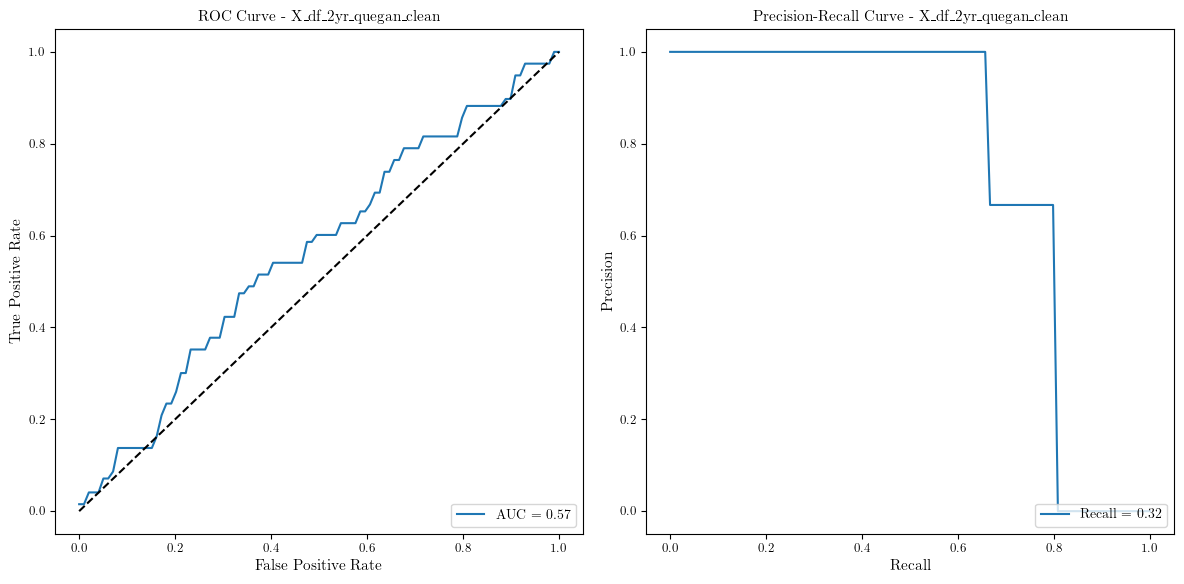

In [572]:
from sklearn.model_selection import ParameterGrid


def fit_and_evaluate_model(df, params, random_states):
    recalls, precisions, rocs = [], [], []
    
    for state in random_states:
        X = df.drop(columns=['gap'])
        y = df['gap']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=state)
        model = xgb.XGBClassifier(random_state=state, eval_metric='logloss', **params)
        model.fit(X_train, y_train, verbose=0)  # `verbose=0` is default, to minimize output
        
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_probs)
        
        recalls.append(recall)
        precisions.append(precision)
        rocs.append((fpr, tpr, roc_auc, precision_vals, recall_vals))
    
    # Average metrics over the random states
    mean_recall = np.mean(recalls)
    mean_precision = np.mean(precisions)
    
    # Ensure all fpr have the same length by interpolating
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _, _, _ in rocs], axis=0)
    mean_roc_auc = np.mean([roc_auc for _, _, roc_auc, _, _ in rocs])
    mean_precision_vals = np.mean([np.interp(mean_fpr, precision_vals[::-1], recall_vals[::-1])[::-1] for _, _, _, precision_vals, recall_vals in rocs], axis=0)
    mean_recall_vals = mean_fpr
    
    return {
        'model': model,  # Final model trained on the last state, but averaged performance metrics
        'recall': mean_recall,
        'precision': mean_precision,
        'fpr': mean_fpr,
        'tpr': mean_tpr,
        'roc_auc': mean_roc_auc,
        'precision_vals': mean_precision_vals,
        'recall_vals': mean_recall_vals
    }

def train_and_select_best_model(dataframes_list, param_grid, random_states):
    best_models = []
    dataset_names = ['X_df_2yr_clean', 'X_df_2yr_frost_clean', 'X_df_2yr_lee_clean',
                     'X_df_2yr_temporal_frost_clean', 'X_df_2yr_temporal_clean',
                     'X_df_2yr_temporal_lee_clean', 'X_df_2yr_quegan_clean',
                     'X_df_2yr_quegan_frost_clean', 'X_df_2yr_quegan3d_clean']
    
    param_combinations = list(ParameterGrid(param_grid))
    i=1
    for params in param_combinations:
        print(f'parameters: {(i)/len(param_combinations)}')
        i=i+1

        best_model = None
        best_dataset_name = None
        
        for df, name in zip(dataframes_list, dataset_names):
            result = fit_and_evaluate_model(df, params, random_states)
            
            if (best_model is None) or (result['recall'] > best_model['recall']) or \
               (result['recall'] == best_model['recall'] and result['precision'] > best_model['precision']):
                best_model = result
                best_dataset_name = name
        
        best_model['dataset_name'] = best_dataset_name
        best_models.append(best_model)
    
    final_best_model = max(best_models, key=lambda x: (x['recall'], x['precision']))
    best_params = final_best_model['model'].get_params()
    
    # Remove the random_state from best_params since it isn't relevant anymore
    best_params.pop('random_state', None)
    
    return final_best_model, best_params

def plot_best_model_roc_and_precision_recall(best_model):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    dataset_name = best_model.get('dataset_name', 'Unknown Dataset')
    
    # Plot ROC curve
    axs[0].plot(best_model['fpr'], best_model['tpr'], label=f'AUC = {best_model["roc_auc"]:.2f}')
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title(f'ROC Curve - {dataset_name}')
    axs[0].legend(loc="lower right")
    
    # Plot Precision-Recall curve
    axs[1].plot(best_model['recall_vals'], best_model['precision_vals'], label=f'Recall = {best_model["recall"]:.2f}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title(f'Precision-Recall Curve - {dataset_name}')
    axs[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

# Example usage with your list of dataframes
feature_dataframes_list = [
    X_df_2yr_clean, X_df_2yr_frost_clean, X_df_2yr_lee_clean,
    X_df_2yr_temporal_frost_clean, X_df_2yr_temporal_clean,
    X_df_2yr_temporal_lee_clean, X_df_2yr_quegan_clean,
    X_df_2yr_quegan_frost_clean, X_df_2yr_quegan3d_clean
]

param_grid = {
    'n_estimators': [200, 250],  # Added 250 as a middle ground
    'max_depth': [3, 4],  # Keeping 3 and 6, adding 4 as an intermediate value
    'learning_rate': [0.15, 0.2],  # Adding 0.05 and 0.15 for finer granularity
    'subsample': [0.85, 0.9],  # Adding 0.7 for more variance
    'colsample_bytree': [0.6, 0.7],  # Adding 0.7 for more variance
    'alpha': [0, 0.01],  # Adding 0.01 and 0.1 for more control over L1 regularization
    'gamma': [0.05, 0.1],  # Adding 0.05 and 0.2 for more control over tree splitting
    'lambda': [0,1],  # Introducing L2 regularization (not in your original grid)
    'min_child_weight': [1, 2],  # Adding min_child_weight to control tree depth
    'scale_pos_weight': [1.2, 1.8],  # Adding scale_pos_weight for imbalanced classes
}

random_states = [52, 62, 72]

best_model, best_params = train_and_select_best_model(feature_dataframes_list, param_grid, random_states)

# Plot the ROC and Precision-Recall curves for the best model
plot_best_model_roc_and_precision_recall(best_model)

# Save best model parameters for reuse
best_model_params = best_params


In [581]:
from sklearn.model_selection import cross_val_score, ParameterGrid
import xgboost as xgb
import numpy as np

def fit_and_evaluate_model_cv(df, params, random_states, cv_folds=5):
    recalls, precisions = [], []

    for state in random_states:
        X = df.drop(columns=['gap'])
        y = df['gap']

        model = xgb.XGBClassifier(random_state=state, eval_metric='logloss', **params)

        # Perform cross-validation
        recall_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='recall')
        precision_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='precision')

        # Average the recall and precision scores across the folds
        mean_recall = np.mean(recall_scores)
        mean_precision = np.mean(precision_scores)

        recalls.append(mean_recall)
        precisions.append(mean_precision)

    # Average metrics over the random states
    overall_mean_recall = np.mean(recalls)
    overall_mean_precision = np.mean(precisions)

    # Fit the model on the entire dataset for final evaluation
    model.fit(X, y, verbose=0)
    
    return {
        'model': model,  # Final model trained on the entire dataset
        'recall': overall_mean_recall,
        'precision': overall_mean_precision
    }

def train_and_select_best_model_cv(dataframes_list, param_grid, random_states, cv_folds=5):
    best_models = []
    dataset_names = ['X_df_2yr_clean', 'X_df_2yr_frost_clean', 'X_df_2yr_lee_clean',
                     'X_df_2yr_temporal_frost_clean', 'X_df_2yr_temporal_clean',
                     'X_df_2yr_temporal_lee_clean', 'X_df_2yr_quegan_clean',
                     'X_df_2yr_quegan_frost_clean', 'X_df_2yr_quegan3d_clean']
    
    param_combinations = list(ParameterGrid(param_grid))
    i = 1
    for params in param_combinations:
        print(f'parameters: {i}/{len(param_combinations)}')
        i += 1

        best_model = None
        best_dataset_name = None
        
        for df, name in zip(dataframes_list, dataset_names):
            result = fit_and_evaluate_model_cv(df, params, random_states, cv_folds)
            
            if (best_model is None) or (result['recall'] > best_model['recall']) or \
               (result['recall'] == best_model['recall'] and result['precision'] > best_model['precision']):
                best_model = result
                best_dataset_name = name
        
        best_model['dataset_name'] = best_dataset_name
        best_models.append(best_model)
    
    final_best_model = max(best_models, key=lambda x: (x['recall'], x['precision']))
    best_params = final_best_model['model'].get_params()
    
    # Remove the random_state from best_params since it isn't relevant anymore
    best_params.pop('random_state', None)
    
    print(f"Best model found on dataset: {final_best_model['dataset_name']}")
    
    return final_best_model, best_params

# Example usage with your list of dataframes
feature_dataframes_list = [
    X_df_2yr_clean, X_df_2yr_frost_clean, X_df_2yr_lee_clean,
    X_df_2yr_temporal_frost_clean, X_df_2yr_temporal_clean,
    X_df_2yr_temporal_lee_clean, X_df_2yr_quegan_clean,
    X_df_2yr_quegan_frost_clean, X_df_2yr_quegan3d_clean
]

param_grid = {
    'n_estimators': [200],  # Added 250 as a middle ground
    'max_depth': [3],  # Keeping 3 and 6, adding 4 as an intermediate value
    'learning_rate': [0.25, 0.2],  # Adding 0.05 and 0.15 for finer granularity
    'subsample': [0.9],  # Adding 0.7 for more variance
    'colsample_bytree': [0.6, 0.7],  # Adding 0.7 for more variance
    'alpha': [0, 0.01],  # Adding 0.01 and 0.1 for more control over L1 regularization
    'gamma': [0.05, 0.1],  # Adding 0.05 and 0.2 for more control over tree splitting
    'lambda': [0, 1],  # Introducing L2 regularization (not in your original grid)
    'min_child_weight': [1.8,2.2],  # Adding min_child_weight to control tree depth
    'scale_pos_weight': [1.2, 1.8],  # Adding scale_pos_weight for imbalanced classes
}

random_states = [52, 62, 72]

best_model, best_params = train_and_select_best_model_cv(feature_dataframes_list, param_grid, random_states)

# Save best model parameters for reuse
best_model_params = best_params


parameters: 1/128
parameters: 2/128
parameters: 3/128
parameters: 4/128
parameters: 5/128
parameters: 6/128
parameters: 7/128
parameters: 8/128
parameters: 9/128


In [580]:
import json

# Save the best_params dictionary to a JSON file
with open('best_params_boost.json', 'w') as f:
    json.dump(best_params, f)


In [573]:
best_model['model']


XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, ...)

In [577]:
joblib.dump(best_model['model'], 'xgb_model.pkl')


['xgb_model.pkl']

In [ ]:
loaded_model = joblib.load('xgb_model.pkl')


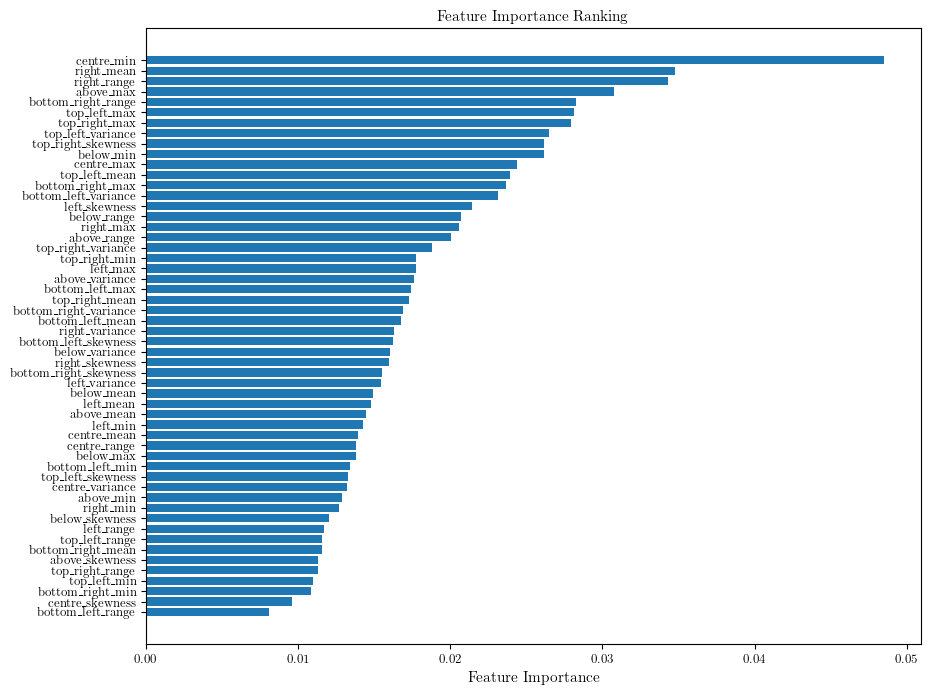

In [532]:
import numpy as np
import matplotlib.pyplot as plt

# Get the feature importance scores
importance = best_model['model'].feature_importances_

# Get feature names (optional)
feature_names = best_model['model'].get_booster().feature_names

# Sort the features by importance
indices = np.argsort(importance)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices] if feature_names is not None else range(len(indices)))
plt.xlabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.show()


## Time Series Classifier

In [ ]:
feature_dataframes_list = [X_df_2yr_clean, X_df_2yr_frost_clean,X_df_2yr_lee_clean,X_df_2yr_temporal_frost_clean,X_df_2yr_temporal_clean,X_df_2yr_temporal_lee_clean,X_df_2yr_quegan_clean,X_df_2yr_quegan_frost_clean,X_df_2yr_quegan3d_clean]

timeseries_dataframes_list = [[df_series_2yr_gaps,df_series_2yr_random],[df_frost_gaps, df_frost_random],[df_lee_gaps, df_lee_random],[df_temporal_gaps,df_temporal_random],[df_temporal_lee_gaps, df_temporal_lee_random],[df_temporal_frost_gaps,df_temporal_frost_random],[df_quegan_gaps,df_quegan_random],[df_quegan_frost_gaps, df_quegan_frost_random],[df_quegan3d_gaps, df_quegan3d_random]]

In [440]:
def extract_central_pixel_data(timeseries_dataframes_list):
    central_pixel_data = []
    
    for sublist in timeseries_dataframes_list:
        central_sublist = []
        for df in sublist:
            # Select columns ending with '_centre'
            centre_columns = [col for col in df.columns if col.endswith('_centre')]
            central_df = df[centre_columns]
            
            # Adjust frequency to every 12 days if needed
            central_df = adjust_frequency_to_12_days(central_df)
            
            central_sublist.append(central_df)
        
        central_pixel_data.append(central_sublist)
    
    return central_pixel_data

def adjust_frequency_to_12_days(df):
    # Assuming the index is a datetime index
    df = df.asfreq('12D', method='pad')  # Use forward fill to handle missing values
    return df

def convert_to_sktime_format(df_pos, df_neg):
    nested_data = []
    targets = []
    
    # Iterate through the positive entries
    for j in range(df_pos.shape[1]):
        # Remove NaNs and convert to numpy array
        cleaned_series = pd.Series(df_pos.iloc[:, j].dropna().to_numpy())
        nested_data.append(cleaned_series)
        targets.append(1)
    
    # Iterate through the negative entries
    for j in range(df_neg.shape[1]):
        # Remove NaNs and convert to numpy array
        cleaned_series = pd.Series(df_neg.iloc[:, j].dropna().to_numpy())
        nested_data.append(cleaned_series)
        targets.append(0)
    
    # Create a DataFrame where each entry is a numpy array (time series)
    nested_df = pd.DataFrame({'time_series': nested_data, 'target': targets})
    return nested_df


df_series_2yr_gaps_centre, df_series_2yr_random_centre = extract_central_pixel_data(df_series_2yr_gaps, df_series_2yr_random)
all_data_df=convert_to_sktime_format(df_series_2yr_gaps_centre, df_series_2yr_random_centre)
y=all_data_df['target'].to_numpy()
all_data_df.drop(columns='target',axis=1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(all_data_df, y)


In [449]:
def convert_to_sktime_format_v2(df_gaps, df_random):
    nested_data = []
    
    # Process gap points (107 gaps)
    for i in range(1, 108):
        # Group columns for the ith gap point
        columns = [f'gap{i}_{location}' for location in ['bottom_left', 'left', 'top_left', 'below', 'centre', 'above', 'bottom_right', 'right', 'top_right']]
        
        # Extract time series for each location and store them as a dictionary
        gap_series_dict = {}
        for j, col in enumerate(columns):
            cleaned_series = pd.Series(df_gaps[col].dropna().to_numpy())
            gap_series_dict[f'location_{j+1}'] = cleaned_series
        
        # Append the dictionary to the nested_data list
        nested_data.append(gap_series_dict)

    # Process random points (3 random points per gap, 321 points in total)
    for i in range(1, 108):
        for k in range(1, 4):
            # Group columns for the ith random point
            columns = [f'gap{i}_random{k}_{location}' for location in ['bottom_left', 'left', 'top_left', 'below', 'centre', 'above', 'bottom_right', 'right', 'top_right']]
            
            # Extract time series for each location and store them as a dictionary
            random_series_dict = {}
            for j, col in enumerate(columns):
                cleaned_series = pd.Series(df_random[col].dropna().to_numpy())
                random_series_dict[f'location_{j+1}'] = cleaned_series
            
            # Append the dictionary to the nested_data list
            nested_data.append(random_series_dict)
    
    # Create a DataFrame from the nested_data, with each row representing a gap or random point's time series
    nested_df = pd.DataFrame(nested_data)
    
    # Create the target array: 107 entries of 1 (gap points) followed by 321 entries of 0 (random points)
    targets = np.array([1] * 107 + [0] * 321)
    
    return nested_df, targets


In [473]:
nested_df,targets=convert_to_sktime_format_v2(df_series_2yr_gaps,df_series_2yr_random)
X_train, X_test, y_train, y_test = train_test_split(nested_df, targets, test_size=0.2, shuffle=True, random_state=42)


In [477]:
pipeline_deep= make_pipeline(
    PaddingTransformer(),
    InceptionTimeClassifier(n_epochs=75, verbose=False)
)


pipeline_deep.fit(X_train, y_train)
pipeline_deep.score(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


0.6162790697674418

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'inceptiontimeclassifier__batch_size': 16, 'inceptiontimeclassifier__depth': 3, 'inceptiontimeclassifier__kernel_size': 30, 'inceptiontimeclassifier__n_epochs': 25, 'inceptiontimeclassifier__n_filters': 32}
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Test set precision with best model: 0.0000


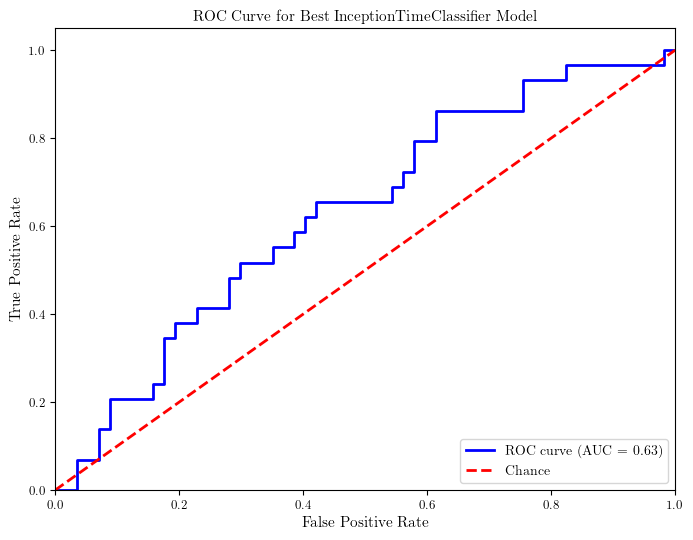

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.98      0.79        57
           1       0.00      0.00      0.00        29

    accuracy                           0.65        86
   macro avg       0.33      0.49      0.39        86
weighted avg       0.44      0.65      0.52        86



In [487]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, classification_report

# Define the pipeline
pipeline_deep = make_pipeline(
    PaddingTransformer(),
    InceptionTimeClassifier()
)

# Define the parameter grid
param_grid = {
    'inceptiontimeclassifier__n_epochs': [10, 25],
    'inceptiontimeclassifier__batch_size': [16, 32],
    'inceptiontimeclassifier__kernel_size': [30],
    'inceptiontimeclassifier__n_filters': [16,32],
    'inceptiontimeclassifier__depth': [3,6]
}

# Setup GridSearchCV with precision as the scoring metric
grid_search = GridSearchCV(
    pipeline_deep,
    param_grid,
    cv=3,                 # 3-fold cross-validation
    scoring='precision',  # Optimize for precision
    verbose=1,            # Controls verbosity (useful for tracking progress)
    n_jobs=-1             # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters found:", grid_search.best_params_)

# Extract the best model
best_model = grid_search.best_estimator_

# Predict probabilities for the test set
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Predict class labels for the test set
y_pred = best_model.predict(X_test)

# Evaluate the precision of the best model
test_precision = precision_score(y_test, y_pred)
print(f"Test set precision with best model: {test_precision:.4f}")

# Get the ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best InceptionTimeClassifier Model')
plt.legend(loc="lower right")
plt.show()

# Optionally, print a classification report
print("Classification Report:\n", classification_report(y_test, y_pred))



In [458]:
# Create a pipeline with PaddingTransformer, TimeSeriesScalerMeanVariance, and ROCKETClassifier
pipeline = make_pipeline(
    PaddingTransformer(),
    RocketClassifier()
)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'rocketclassifier__num_kernels': [5000, 10000]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the pipeline to the training data with grid search
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_estimator = grid_search.best_estimator_

# Predict the test data
y_pred = best_estimator.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")

# If you want to see the cross-validation scores
cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")

Best Parameters: {'rocketclassifier__num_kernels': 5000}
Accuracy: 0.6395348837209303
Cross-validation scores: [0.73913043 0.66666667 0.72058824 0.70588235 0.72058824]
Mean cross-validation accuracy: 0.7105711849957375


In [464]:
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from sklearn.pipeline import make_pipeline


padded_rocket_clf = make_pipeline(
    PaddingTransformer(),
    RocketClassifier()
)

padded_rocket_clf.fit(X_train, y_train)
y_pred = padded_rocket_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.627906976744186

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


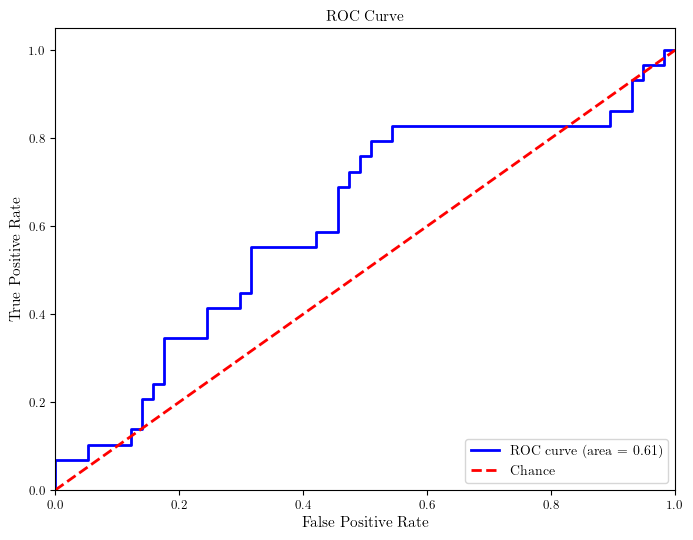

In [479]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Step 1: Fit the model (already done)
# padded_rocket_clf.fit(X_train, y_train)

# Step 2: Get predicted probabilities for the positive class
y_proba = pipeline_deep.predict_proba(X_test)[:, 1]

# Step 3: Calculate the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Step 4: Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Step 5: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


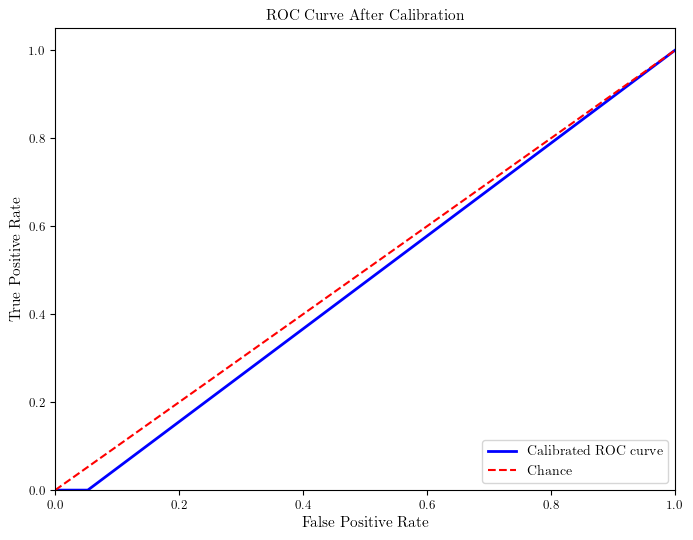

In [471]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(padded_rocket_clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_train, y_train)
y_proba_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]

fpr_calibrated, tpr_calibrated, _ = roc_curve(y_test, y_proba_calibrated)
plt.figure(figsize=(8, 6))
plt.plot(fpr_calibrated, tpr_calibrated, color='blue', lw=2, label='Calibrated ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve After Calibration')
plt.legend(loc="lower right")
plt.show()




In [478]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assuming you already have y_test and y_pred from your fitted classifier

# Calculate precision score
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate recall score
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score:", f1)

# Get detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Precision: 0.3253012048192771
Recall: 0.47368421052631576
F1 Score: 0.3857142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.95      0.77        57
           1       0.00      0.00      0.00        29

    accuracy                           0.63        86
   macro avg       0.33      0.47      0.39        86
weighted avg       0.43      0.63      0.51        86



In [343]:
from sklearn.metrics import precision_score

Best Parameters: {'rocketclassifier__num_kernels': 3000}
Accuracy: 0.6395348837209303
AUC: 0.4824561403508772


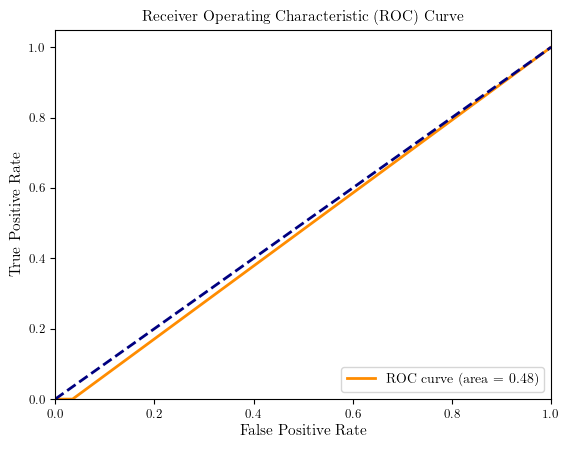

In [462]:
# Import necessary modules
from sktime.transformations.panel.padder import PaddingTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Simplify the pipeline for debugging
pipeline = make_pipeline(
    PaddingTransformer(),
    RocketClassifier()
)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'rocketclassifier__num_kernels': [3000,5000],  # Adjust this based on the computational resources
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='precision')

# Fit the pipeline to the training data with grid search
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_estimator = grid_search.best_estimator_

# Predict the test data using the best model
y_pred = best_estimator.predict(X_test)

# Predict probabilities for ROC curve
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]  # Assuming binary classification

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [413]:
# Import necessary modules
from sktime.classification.kernel_based import ROCKETClassifier
from sktime.transformations.panel.padder import PaddingTransformer
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have already loaded your data
# X_train, y_train, X_test, y_test = load_unit_test(split="train"), load_unit_test(split="test")

# Create a pipeline with PaddingTransformer, TimeSeriesScalerMeanVariance, and ROCKETClassifier
pipeline = make_pipeline(
    PaddingTransformer(),
    TimeSeriesScalerMeanVariance(),
)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Lower the probability threshold
threshold = 0.3  # Adjust this value as needed
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate the accuracy with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
print(f"Accuracy with adjusted threshold: {accuracy}")

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ImportError: cannot import name 'ROCKETClassifier' from 'sktime.classification.kernel_based' (c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\sktime\classification\kernel_based\__init__.py)